# Pose Linear Metrics Statistical Analysis

This notebook performs comprehensive statistical analysis on all pose linear metrics using mixed-effects models and generates publication-ready figures.

## Important
Before using this notebook:
1. Download the raw pose data
2. Run `process_pose_data.py`

## Setup and Imports

To start, let's import relevant libraries and set the metrics for analysis:

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Ensure root directory is in the path for imports
sys.path.append('..')  
from stats_figures import run_rpy2_lmer, barplot_ax
import statsmodels.formula.api as smf

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


## Load Data

Load and optionally combine data across different methods (original vs. procrustes aligned data):

In [2]:
# Get processed data for further analysis
data_dir = Path("data") / "processed" / "linear_metrics"
methods_to_load = ["original", "procrustes_global", "procrustes_participant"]

# Load and concatenate all pose linear metrics files
pose_dfs = []
for method in methods_to_load:
    file_path = data_dir / f"{method}_linear.csv"
    if file_path.exists():
        df = pd.read_csv(file_path)
        df["method"] = method

        # Standardise participant ID column name
        if "participant" in df.columns:
            df = df.rename(columns={"participant": "participant_id"})

        pose_dfs.append(df)
        print(f"Loaded {method}: {df.shape[0]} rows")
    else:
        print(f"Warning: {file_path.name} not found")

if not pose_dfs:
    raise FileNotFoundError("No pose linear metrics files found.")

pose_metrics_df = pd.concat(pose_dfs, ignore_index=True)
print(f"Combined DataFrame shape: {pose_metrics_df.shape}")

Loaded original: 281 rows
Loaded procrustes_global: 281 rows
Loaded procrustes_participant: 281 rows
Combined DataFrame shape: (843, 46)


## Select Metrics for Analysis

In [7]:
# Option 1: Analyze ALL metrics (overrides other options if True)
ANALYZE_ALL_METRICS = True

# Option 2: Analyze specific metrics by name
SELECTED_METRICS = [
    # --- Head rotation metrics ---
    "head_rotation_rad_mean_abs_vel",
    "head_rotation_rad_rms",

    # --- Blink metrics ---
    "blink_aperture_mean_abs_vel",
    "blink_aperture_rms",

    # --- Mouth metrics ---
    "mouth_aperture_mean_abs_vel",
    "mouth_aperture_rms",

    # --- Pupil metrics ---
    "pupil_dx_rms",
    "pupil_dy_rms",
    "pupil_metric_rms",

    # --- Center face metrics ---
    "center_face_magnitude_rms",
    "center_face_x_rms",
    "center_face_y_rms",
]

## Load Session Info

Load session info for all participants and add relevant dependent variables to pose_metrics_df:

In [8]:
# Load session information
session_dir = Path("data") / "pose_data"
Session_Info = pd.read_csv(
    os.path.join(session_dir,"participant_info.csv")
)

# Add session_order string
if {"session01", "session02", "session03"}.issubset(Session_Info.columns):
    Session_Info["session_order"] = (
        Session_Info["session01"].str[0] +
        Session_Info["session02"].str[0] +
        Session_Info["session03"].str[0]
    )

session_order_numeric_map = {"LMH": 1, "LHM": 2}

# === Derive condition from participant_info ===
def get_condition(row):
    pid = int(row['participant_id'])
    # If session_number is already present, map directly
    if "session_number" in row and not pd.isna(row["session_number"]):
        session_col = f"session{int(row['session_number']):02d}"
        if session_col in Session_Info.columns:
            cond = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
            if len(cond) > 0:
                return cond[0]
    # Otherwise try matching to session01–03
    for s_num in [1, 2, 3]:
        session_col = f"session{s_num:02d}"
        if session_col in Session_Info.columns:
            cond_val = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
            if len(cond_val) > 0:
                # If this condition matches the pose row's 'condition' (if present), use this session
                if "condition" in row and str(row["condition"]).strip().upper() == str(cond_val[0]).strip().upper():
                    return cond_val[0]
    return None

# === Derive session_number by reverse lookup ===
def get_session_number(row):
    pid = int(row['participant_id'])
    row_cond = str(row.get('condition', '')).strip().upper()
    if row_cond in {"L", "M", "H"}:
        for s_num in [1, 2, 3]:
            session_col = f"session{s_num:02d}"
            if session_col in Session_Info.columns:
                val = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
                if len(val) > 0 and str(val[0]).strip().upper() == row_cond:
                    return s_num
    return np.nan

# Apply mapping
pose_metrics_df["condition"] = pose_metrics_df.apply(get_condition, axis=1)
pose_metrics_df["condition"] = pose_metrics_df["condition"].astype(str).str.strip().str.upper()
pose_metrics_df["session_number"] = pose_metrics_df.apply(get_session_number, axis=1)

# === Map session_order_numeric ===
if "session_order" in Session_Info.columns:
    session_info_numeric_map = Session_Info.set_index("Participant ID")["session_order"].map(session_order_numeric_map).to_dict()
    pose_metrics_df["session_order_numeric"] = pose_metrics_df["participant_id"].astype(int).map(session_info_numeric_map)

# Select metrics
metadata_cols = {
    "source", "participant_id", "condition", "window_index",
    "t_start_frame", "t_end_frame", "session_order", "session_order_numeric",
    "session_number", "method"
}

all_metric_cols = [c for c in pose_metrics_df.columns if c not in metadata_cols]

if ANALYZE_ALL_METRICS:
    # Use all metrics
    metric_cols = all_metric_cols

elif SELECTED_METRICS:
    # Use only explicitly listed metrics, warn for missing
    metric_cols = [col for col in SELECTED_METRICS if col in all_metric_cols]
    missing = [col for col in SELECTED_METRICS if col not in all_metric_cols]
    if missing:
        print(f"⚠️ Warning: {len(missing)} selected metrics not found:\n  - " + "\n  - ".join(missing))

else:
    raise ValueError("No metric selection mode specified. Enable one of: "
                     "ANALYZE_ALL_METRICS, SELECTED_METRICS, or METRIC_PATTERNS")

print(f"\n✅ Selected {len(metric_cols)} metrics for analysis:")
for m in metric_cols:
    print(f"  - {m}")


✅ Selected 39 metrics for analysis:
  - head_rotation_rad_mean_abs_vel
  - head_rotation_rad_mean_abs_acc
  - head_rotation_rad_rms
  - blink_aperture_mean_abs_vel
  - blink_aperture_mean_abs_acc
  - blink_aperture_rms
  - mouth_aperture_mean_abs_vel
  - mouth_aperture_mean_abs_acc
  - mouth_aperture_rms
  - pupil_dx_mean_abs_vel
  - pupil_dx_mean_abs_acc
  - pupil_dx_rms
  - pupil_dy_mean_abs_vel
  - pupil_dy_mean_abs_acc
  - pupil_dy_rms
  - pupil_metric_mean_abs_vel
  - pupil_metric_mean_abs_acc
  - pupil_metric_rms
  - center_face_magnitude_mean_abs_vel
  - center_face_magnitude_mean_abs_acc
  - center_face_magnitude_rms
  - center_face_x_mean_abs_vel
  - center_face_x_mean_abs_acc
  - center_face_x_rms
  - center_face_y_mean_abs_vel
  - center_face_y_mean_abs_acc
  - center_face_y_rms
  - head_tx_mean_abs_vel
  - head_tx_mean_abs_acc
  - head_tx_rms
  - head_ty_mean_abs_vel
  - head_ty_mean_abs_acc
  - head_ty_rms
  - head_scale_mean_abs_vel
  - head_scale_mean_abs_acc
  - head_s

## Run Statistic Analyses and Plots

Run stats and make plots for the metrics of interest:

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



Analyzing original normalization method...
Means for head_rotation_rad_mean_abs_vel:
  H: 0.220
  L: 0.204
  M: 0.205

=== original_head_rotation_rad_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -891.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7927 -0.4837 -0.1684  0.3055  5.5025 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0004799 0.02191 
 Residual                   0.0019738 0.04443 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   2.019e-01  1.407e-02  1.900e+00  14.351  0.00591 **
condition.L   6.810e-03  8.883e-03  2.716e+02   0.767  0.44397   
condition.Q   1.048e-02  8.913e-03  2.669e+02   1.175  0.24088   
wi

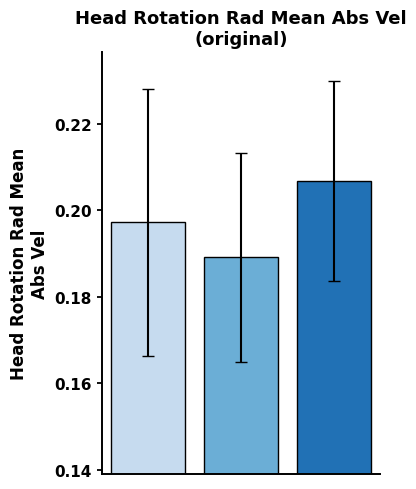

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_rotation_rad_mean_abs_acc:
  H: 7.825
  L: 7.653
  M: 7.823

=== original_head_rotation_rad_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1209

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2948 -0.4085 -0.1574  0.1367  6.5601 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.6908   0.8311  
 Residual                   4.4737   2.1151  
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)    7.463232   0.560678   1.838170  13.311   0.0077 **
condition.L   -0.100605   0.422476 271.978152  -0.238   0.8120   
condition.Q    0.054240   0.422561 255.653925   0.128   0.8980   
window_index  -0.003323   0.002486 257.498075  -1.3

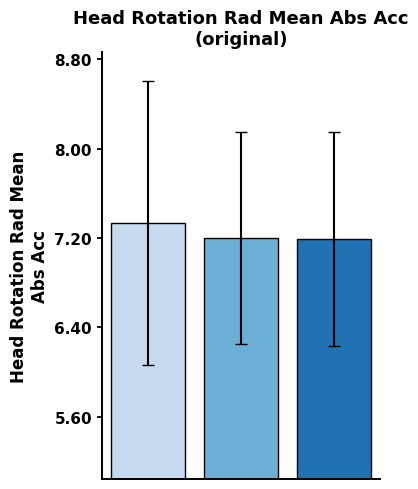

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_rotation_rad_rms:
  H: 0.051
  L: 0.052
  M: 0.047

=== original_head_rotation_rad_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1343.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5257 -0.5845 -0.1841  0.2929  5.3545 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0001755 0.01325 
 Residual                   0.0003730 0.01931 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)   
(Intercept)  5.599e-02  8.115e-03 2.020e+00   6.900  0.01985 * 
condition.L  4.535e-03  3.866e-03 2.710e+02   1.173  0.24176   
condition.Q  2.705e-03  3.891e-03 2.717e+02   0.695  0.48752   
window_index 7.447e-05  2.288e-05 2.719e+02   3.255  0.00128 **
---
Sig

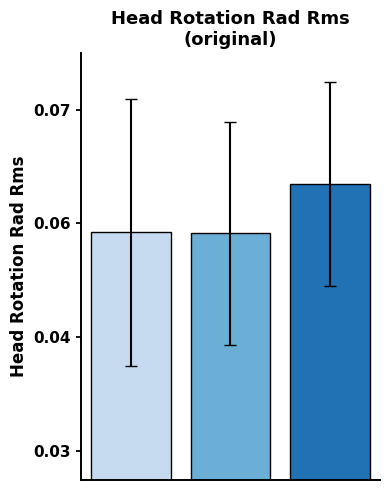

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for blink_aperture_mean_abs_vel:
  H: 0.199
  L: 0.176
  M: 0.183

=== original_blink_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -890.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4942 -0.4989 -0.1031  0.1782  4.8068 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0001832 0.01354 
 Residual                   0.0021167 0.04601 
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   1.805e-01  9.930e-03  2.715e+00  18.175 0.000648 ***
condition.L   1.351e-02  9.166e-03  2.766e+02   1.474 0.141640    
condition.Q  -3.675e-03  9.123e-03  2.425e+02  -0.403 0.687448    
window_index -2.888e-05  5.307e-05  2.408e+02  -

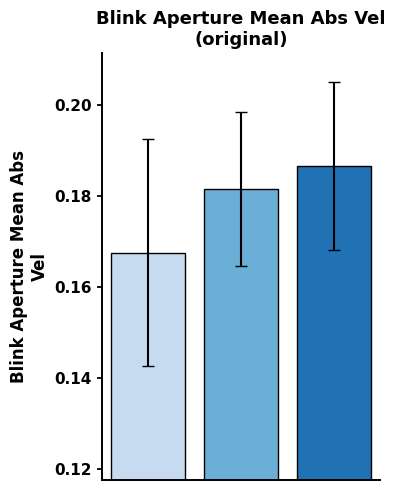

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for blink_aperture_mean_abs_acc:
  H: 7.097
  L: 6.424
  M: 6.553

=== original_blink_aperture_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1321.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9574 -0.3827 -0.1617  0.0215  5.1043 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.1624   0.403   
 Residual                   6.2641   2.503   
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   6.549e+00  3.912e-01  2.665e+00  16.739 0.000894 ***
condition.L   4.350e-01  4.958e-01  2.680e+02   0.877 0.381080    
condition.Q  -2.019e-02  4.860e-01  1.640e+02  -0.042 0.966917    
window_index -1.365e-04  2.821e-03  1.411e+02  -0.0

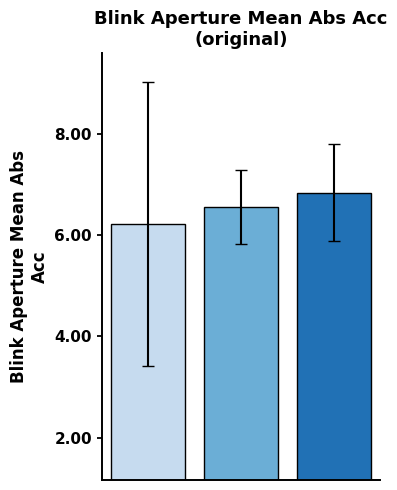

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for blink_aperture_rms:
  H: 0.047
  L: 0.047
  M: 0.053

=== original_blink_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1284.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0635 -0.3763 -0.0813  0.0701  6.5957 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0000238 0.004878
 Residual                   0.0005121 0.022630
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   4.780e-02  4.065e-03  2.171e+00  11.759  0.00527 **
condition.L  -3.698e-04  4.496e-03  2.730e+02  -0.082  0.93451   
condition.Q  -7.758e-03  4.442e-03  1.904e+02  -1.746  0.08234 . 
window_index  3.300e-06  2.582e-05  1.777e+02   0.128  0.89846   
---

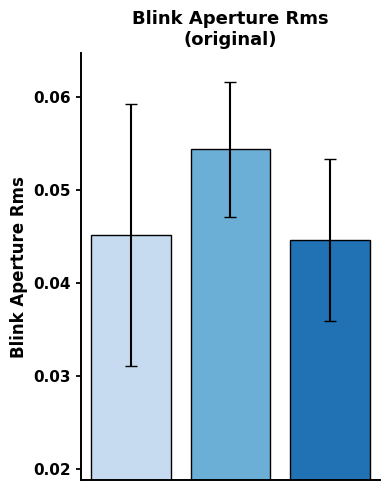

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for mouth_aperture_mean_abs_vel:
  H: 0.178
  L: 0.102
  M: 0.089

=== original_mouth_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -853.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0998 -0.5668 -0.1326  0.2719  4.0660 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 1.736e-05 0.004167
 Residual                   2.304e-03 0.047996
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  1.209e-01  6.186e-03 2.158e+00  19.538  0.00181 ** 
condition.L  6.034e-02  9.461e-03 2.470e+02   6.378 8.78e-10 ***
condition.Q  3.922e-02  9.137e-03 1.054e+02   4.292 3.94e-05 ***
window_index 1.256e-04  5.350e-05 8.014e+01   2.347  0.0

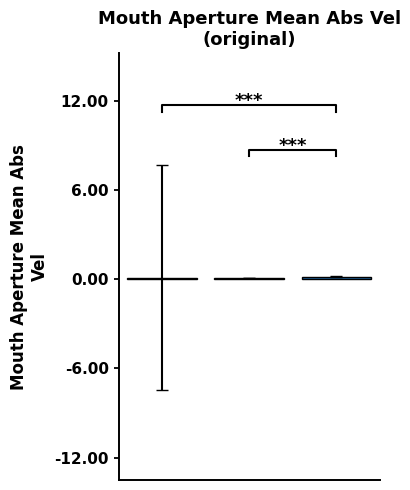

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for mouth_aperture_mean_abs_acc:
  H: 7.106
  L: 4.788
  M: 4.413

=== original_mouth_aperture_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1037.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9518 -0.5721 -0.0718  0.3190  3.9036 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.1326   0.3642  
 Residual                   2.3960   1.5479  
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  5.481e+00  2.926e-01 2.791e+00  18.735  0.00051 ***
condition.L  1.974e+00  3.080e-01 2.702e+02   6.407 6.57e-10 ***
condition.Q  1.251e+00  3.048e-01 2.145e+02   4.104 5.77e-05 ***
window_index 5.839e-03  1.793e-03 2.094e+02   3.256  0.0013

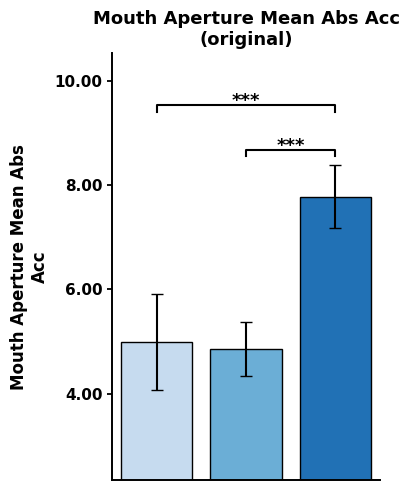

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for mouth_aperture_rms:
  H: 0.036
  L: 0.017
  M: 0.011

=== original_mouth_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1539

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6895 -0.8029 -0.3245  0.5370  3.5245 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 1.874e-05 0.004329
 Residual                   1.836e-04 0.013551
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   1.939e-02  3.098e-03  1.750e+00   6.259   0.0337 *  
condition.L   1.343e-02  2.703e-03  2.718e+02   4.970 1.19e-06 ***
condition.Q   1.270e-02  2.694e-03  2.349e+02   4.716 4.14e-06 ***
window_index -7.281e-06  1.585e-05  2.358e+02  -0.459   0.6464    


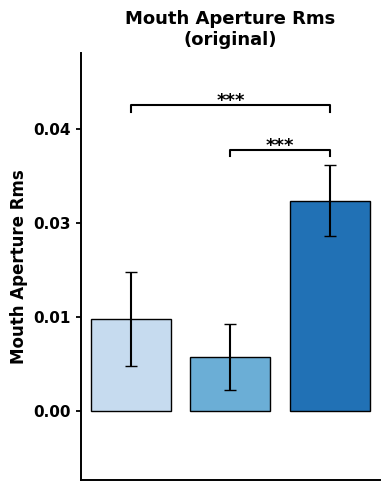

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for pupil_dx_mean_abs_vel:
  H: 0.055
  L: 0.057
  M: 0.056

=== original_pupil_dx_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1049.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5115 -0.2950 -0.1719 -0.0864  5.9816 

Random effects:
 Groups         Name        Variance  Std.Dev. 
 participant_id (Intercept) 3.473e-18 1.864e-09
 Residual                   1.203e-03 3.469e-02
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   5.599e-02  3.905e-03  2.770e+02  14.336   <2e-16 ***
condition.L  -1.666e-03  6.796e-03  2.770e+02  -0.245    0.807    
condition.Q   3.895e-04  6.491e-03  2.770e+02   0.060    0.952    
window_index -2.017e-06  3.731e-05  2.770e+02  -0.054   

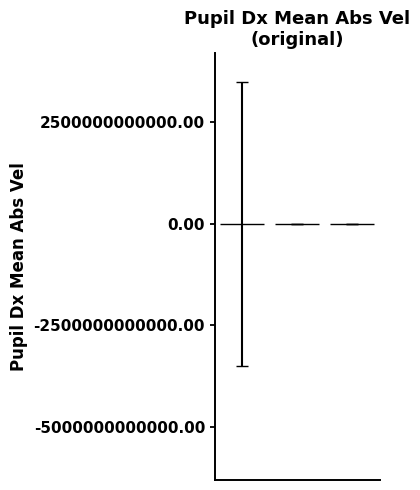

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for pupil_dx_mean_abs_acc:
  H: 2.198
  L: 2.310
  M: 2.175

=== original_pupil_dx_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1071.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5008 -0.2798 -0.1763 -0.1062  5.5796 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.000    0.000   
 Residual                   2.544    1.595   
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   2.214e+00  1.796e-01  2.770e+02  12.331   <2e-16 ***
condition.L  -5.812e-02  3.125e-01  2.770e+02  -0.186    0.853    
condition.Q   5.212e-02  2.985e-01  2.770e+02   0.175    0.862    
window_index  4.252e-04  1.716e-03  2.770e+02   0.248    0.804 

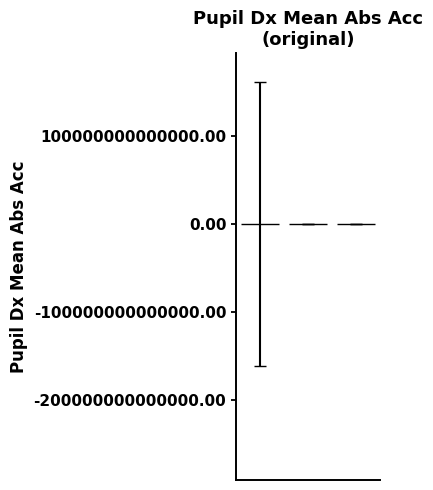

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dx_rms:
  H: 0.005
  L: 0.010
  M: 0.012

=== original_pupil_dx_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1143.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2945 -0.2043 -0.1786 -0.1498  6.9835 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 7.653e-06 0.002766
 Residual                   8.550e-04 0.029241
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)
(Intercept)   8.500e-03  3.837e-03  2.254e+00   2.215    0.143
condition.L  -3.944e-03  5.762e-03  2.518e+02  -0.684    0.494
condition.Q  -3.985e-03  5.577e-03  1.113e+02  -0.714    0.476
window_index -1.111e-05  3.225e-05  8.026e+01  -0.345    0.731

Correlation of Fixed Effects:

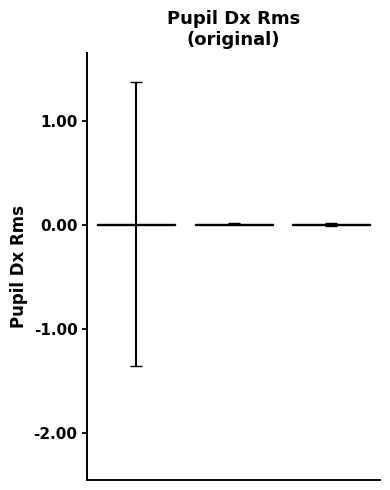

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dy_mean_abs_vel:
  H: 0.113
  L: 0.110
  M: 0.108

=== original_pupil_dy_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -784

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7346 -0.3408 -0.1900  0.0091  5.6156 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 2.454e-05 0.004954
 Residual                   3.136e-03 0.055997
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   1.090e-01  7.235e-03  2.160e+00  15.070  0.00316 **
condition.L   1.985e-03  1.103e-02  2.494e+02   0.180  0.85732   
condition.Q   1.812e-03  1.066e-02  1.059e+02   0.170  0.86539   
window_index -2.272e-06  6.162e-05  7.484e+01  -0.037  0.97069   


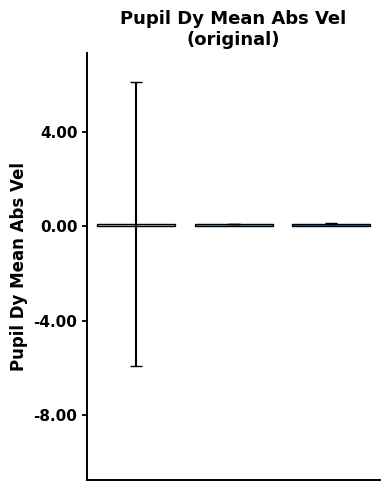

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for pupil_dy_mean_abs_acc:
  H: 4.429
  L: 4.409
  M: 4.157

=== original_pupil_dy_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1385.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6489 -0.3121 -0.1717 -0.0126  6.5302 

Random effects:
 Groups         Name        Variance  Std.Dev. 
 participant_id (Intercept) 9.193e-15 9.588e-08
 Residual                   7.910e+00 2.812e+00
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  4.299e+00  3.166e-01 2.770e+02  13.577   <2e-16 ***
condition.L  6.770e-02  5.510e-01 2.770e+02   0.123    0.902    
condition.Q  1.828e-01  5.263e-01 2.770e+02   0.347    0.729    
window_index 1.068e-03  3.025e-03 2.770e+02   0.353    0.724    


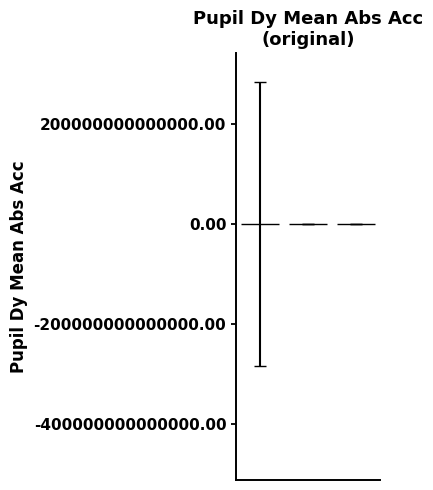

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dy_rms:
  H: 0.013
  L: 0.019
  M: 0.021

=== original_pupil_dy_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -990.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.3156 -0.2180 -0.1874 -0.1519  6.4820 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 3.923e-06 0.001981
 Residual                   1.490e-03 0.038606
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   1.733e-02  4.586e-03  1.615e+00   3.779   0.0875 .
condition.L  -4.131e-03  7.580e-03  2.323e+02  -0.545   0.5862  
condition.Q  -4.284e-03  7.275e-03  7.776e+01  -0.589   0.5577  
window_index  4.183e-07  4.191e-05  4.943e+01   0.010   0.9921  
---
Signif. codes:  0

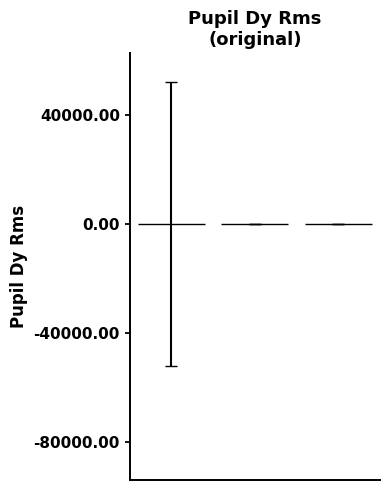

Means for pupil_metric_mean_abs_vel:
  H: 0.085
  L: 0.086
  M: 0.084


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



=== original_pupil_metric_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -733.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5901 -0.3340 -0.1764 -0.0406  5.1607 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 2.478e-05 0.004978
 Residual                   3.770e-03 0.061399
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   8.395e-02  7.789e-03  2.125e+00  10.778  0.00686 **
condition.L  -1.349e-03  1.208e-02  2.473e+02  -0.112  0.91120   
condition.Q   2.546e-04  1.166e-02  1.020e+02   0.022  0.98263   
window_index -8.587e-06  6.737e-05  7.077e+01  -0.127  0.89894   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1

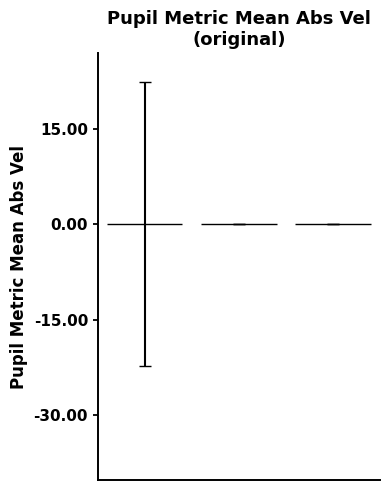

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for pupil_metric_mean_abs_acc:
  H: 3.509
  L: 3.717
  M: 3.476

=== original_pupil_metric_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1484.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5378 -0.2885 -0.1809 -0.0765  6.0820 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)  0.00    0.000   
 Residual                   11.31    3.363   
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    3.532245   0.378654 277.000000   9.328   <2e-16 ***
condition.L   -0.088771   0.658951 277.000000  -0.135    0.893    
condition.Q    0.078195   0.629374 277.000000   0.124    0.901    
window_index   0.001153   0.003618 277.000000   0.319  

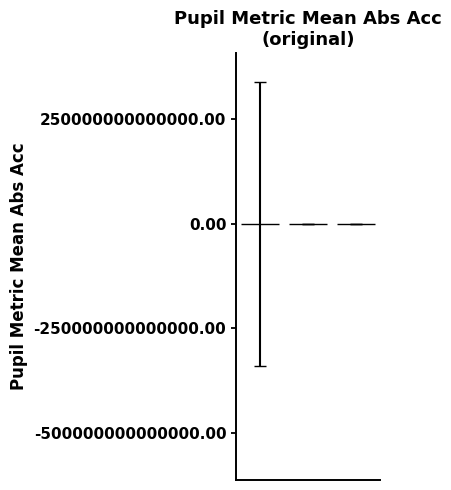

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_metric_rms:
  H: 0.009
  L: 0.017
  M: 0.019

=== original_pupil_metric_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -857.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2875 -0.2044 -0.1863 -0.1662  6.6760 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 1.522e-05 0.003901
 Residual                   2.409e-03 0.049076
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)
(Intercept)   1.426e-02  6.202e-03  1.987e+00   2.300    0.149
condition.L  -6.388e-03  9.658e-03  2.450e+02  -0.661    0.509
condition.Q  -6.185e-03  9.319e-03  9.712e+01  -0.664    0.508
window_index -9.814e-06  5.382e-05  6.664e+01  -0.182    0.856

Correlation of Fixed E

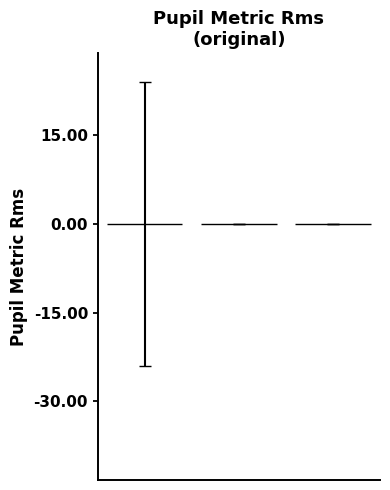

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for center_face_magnitude_mean_abs_vel:
  H: 0.408
  L: 0.289
  M: 0.269

=== original_center_face_magnitude_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -135

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2557 -0.4575 -0.1652  0.1918  6.1225 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.005306 0.07284 
 Residual                   0.031958 0.17877 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   2.853e-01  4.871e-02  2.419e+00   5.858   0.0176 *
condition.L   4.724e-02  3.571e-02  2.720e+02   1.323   0.1871  
condition.Q   4.845e-02  3.574e-02  2.613e+02   1.356   0.1764  
window_index -5.408e-04  2.103e-04  2.627e+02  

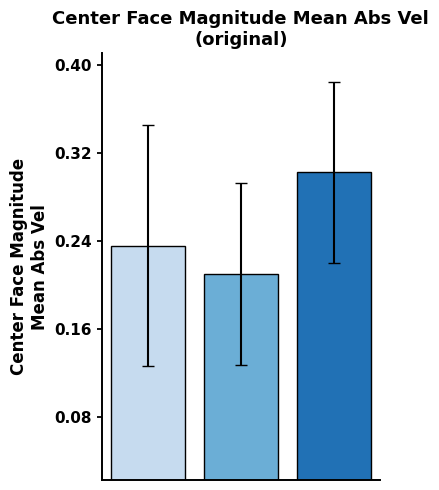

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for center_face_magnitude_mean_abs_acc:
  H: 6.614
  L: 6.016
  M: 6.280

=== original_center_face_magnitude_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1974

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5284 -0.2599 -0.1587 -0.0273  7.2793 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)  2.868   1.693   
 Residual                   75.007   8.661   
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)    5.730729   1.483981   2.674426   3.862   0.0376 *
condition.L   -0.412834   1.720505 267.657360  -0.240   0.8106  
condition.Q   -0.278535   1.694500 187.897776  -0.164   0.8696  
window_index  -0.013048   0.009964 176.757213  

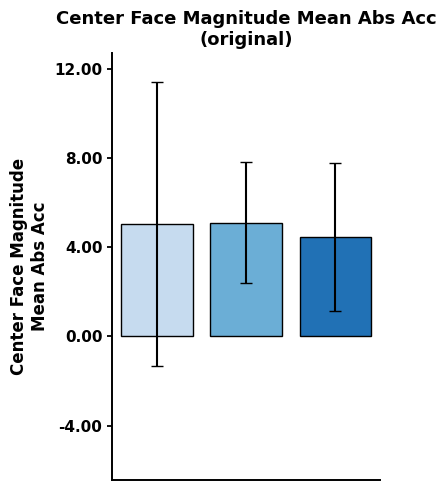

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for center_face_magnitude_rms:
  H: 0.202
  L: 0.177
  M: 0.175

=== original_center_face_magnitude_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -365.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0070 -0.3959 -0.1194  0.0841  6.7297 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0007418 0.02724 
 Residual                   0.0137813 0.11739 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   1.744e-01  2.201e-02  2.871e+00   7.920  0.00491 **
condition.L   4.313e-03  2.336e-02  2.701e+02   0.185  0.85365   
condition.Q   4.450e-03  2.311e-02  2.140e+02   0.193  0.84748   
window_index -2.004e-04  1.359e-04  2.086e+02  -1.474  0

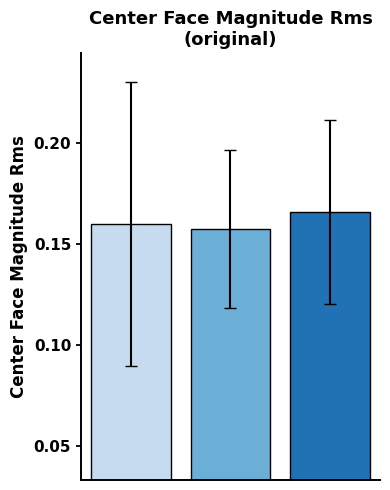

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for center_face_x_mean_abs_vel:
  H: 0.337
  L: 0.214
  M: 0.188

=== original_center_face_x_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -343.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5838 -0.4941 -0.1832  0.1634  5.3154 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.002831 0.05321 
 Residual                   0.014813 0.12171 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   2.185e-01  3.501e-02  2.379e+00   6.242   0.0159 *
condition.L   6.166e-02  2.432e-02  2.719e+02   2.535   0.0118 *
condition.Q   5.854e-02  2.437e-02  2.642e+02   2.402   0.0170 *
window_index -3.695e-04  1.433e-04  2.655e+02  -2.578   0.010

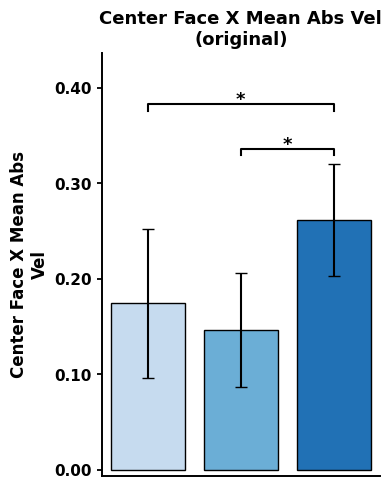

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for center_face_x_mean_abs_acc:
  H: 5.179
  L: 4.116
  M: 4.055

=== original_center_face_x_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1700.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6173 -0.2930 -0.1811 -0.0097  7.2299 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)  1.468   1.211   
 Residual                   27.438   5.238   
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)    3.975743   0.980548   2.676369   4.055   0.0334 *
condition.L    0.161431   1.042262 269.937422   0.155   0.8770  
condition.Q    0.234206   1.030984 210.289113   0.227   0.8205  
window_index  -0.008994   0.006065 204.618781  -1.483   0.139

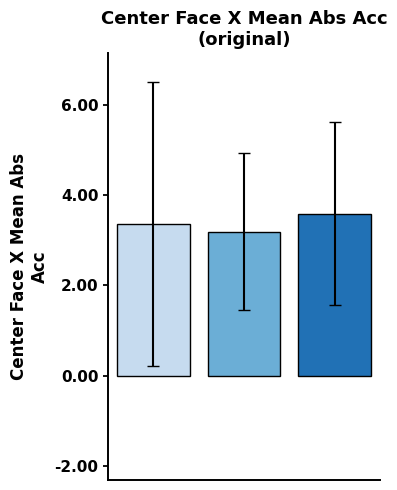

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for center_face_x_rms:
  H: 0.160
  L: 0.130
  M: 0.130

=== original_center_face_x_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -635.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3499 -0.4838 -0.1375  0.2808  6.1863 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0001567 0.01252 
 Residual                   0.0051228 0.07157 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   1.360e-01  1.163e-02  2.853e+00  11.692   0.0017 **
condition.L   1.697e-02  1.420e-02  2.660e+02   1.195   0.2333   
condition.Q   7.946e-03  1.395e-02  1.777e+02   0.570   0.5695   
window_index -5.600e-05  8.198e-05  1.631e+02  -0.683   0.4955   
---
Si

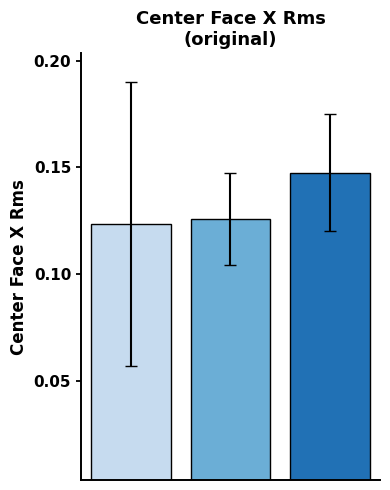

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for center_face_y_mean_abs_vel:
  H: 0.350
  L: 0.268
  M: 0.257

=== original_center_face_y_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -260.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3686 -0.4343 -0.1399  0.1664  6.3695 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.002524 0.05024 
 Residual                   0.020147 0.14194 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   2.679e-01  3.485e-02  2.431e+00   7.685  0.00923 **
condition.L   3.340e-02  2.833e-02  2.720e+02   1.179  0.23946   
condition.Q   3.245e-02  2.829e-02  2.528e+02   1.147  0.25251   
window_index -3.713e-04  1.665e-04  2.542e+02  -2.231  0.

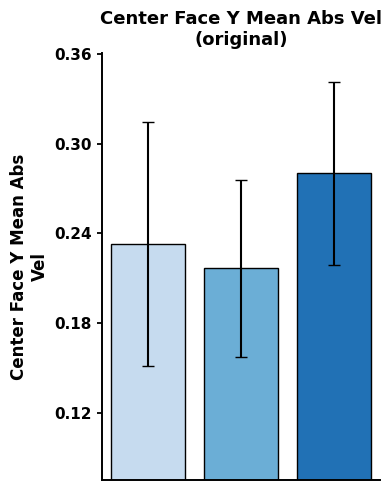

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for center_face_y_mean_abs_acc:
  H: 6.412
  L: 5.987
  M: 6.172

=== original_center_face_y_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1869.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5883 -0.2613 -0.1647 -0.0259  7.2213 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)  1.544   1.243   
 Residual                   51.119   7.150   
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)    5.820252   1.158650   2.526735   5.023   0.0227 *
condition.L   -0.324706   1.418657 265.153678  -0.229   0.8191  
condition.Q   -0.143418   1.392820 169.214671  -0.103   0.9181  
window_index  -0.009982   0.008187 154.065690  -1.219   0.224

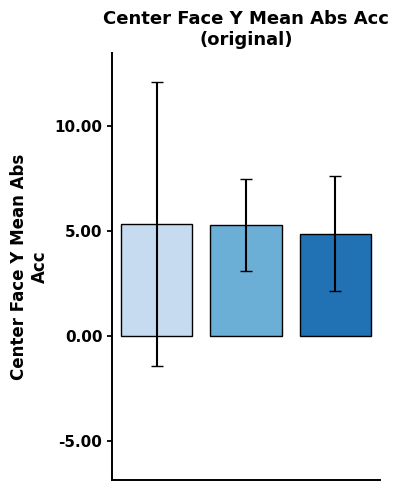

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for center_face_y_rms:
  H: 0.168
  L: 0.149
  M: 0.148

=== original_center_face_y_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -485.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9573 -0.3748 -0.1729  0.0697  6.7408 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0004344 0.02084 
 Residual                   0.0088759 0.09421 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   1.468e-01  1.721e-02  2.564e+00   8.529    0.006 **
condition.L   3.102e-03  1.874e-02  2.693e+02   0.166    0.869   
condition.Q   5.263e-03  1.851e-02  2.022e+02   0.284    0.777   
window_index -1.505e-04  1.089e-04  1.950e+02  -1.382    0.168   
---
Si

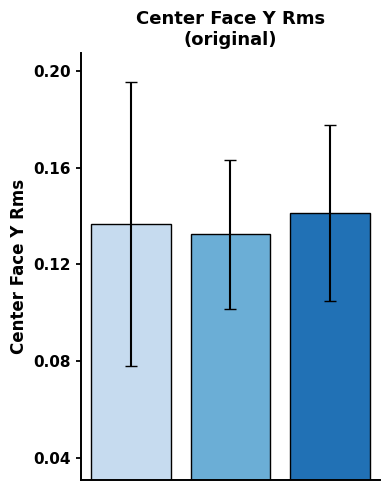

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



Analyzing procrustes_global normalization method...
Means for head_rotation_rad_mean_abs_vel:
  H: 0.199
  L: 0.193
  M: 0.197

=== procrustes_global_head_rotation_rad_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -743.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2120 -0.3780 -0.1353  0.1407  6.7920 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0003218 0.01794 
 Residual                   0.0034231 0.05851 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   1.891e-01  1.301e-02  1.811e+00  14.533  0.00694 **
condition.L  -1.948e-03  1.167e-02  2.716e+02  -0.167  0.86752   
condition.Q   5.530e-04  1.162e-02  2.310e+02   0.

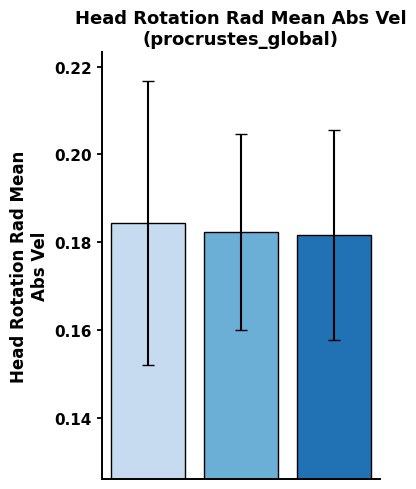

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_rotation_rad_mean_abs_acc:
  H: 7.497
  L: 7.670
  M: 8.152

=== procrustes_global_head_rotation_rad_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1631.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6044 -0.2611 -0.1439 -0.0125  7.2794 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)  0.582   0.7629  
 Residual                   21.296   4.6148  
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)    7.539471   0.731474   2.288230  10.307  0.00577 **
condition.L   -0.472914   0.915193 263.278868  -0.517  0.60577   
condition.Q   -0.545770   0.897319 156.555526  -0.608  0.54392   
window_index  -0.005546   0.005273 139.7

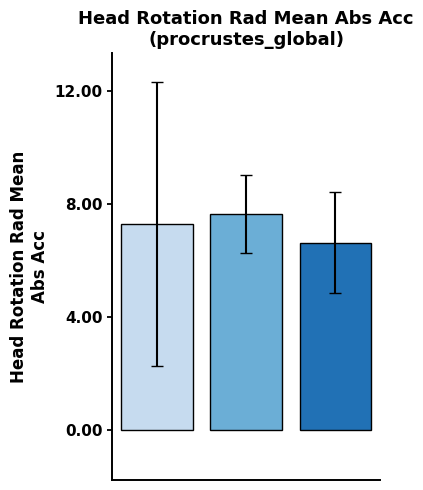

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_rotation_rad_rms:
  H: 0.033
  L: 0.035
  M: 0.035

=== procrustes_global_head_rotation_rad_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1259

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7266 -0.3163 -0.1617  0.0125  7.0059 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0000000 0.00000 
 Residual                   0.0005192 0.02279 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   3.429e-02  2.568e-03  2.720e+02  13.352   <2e-16 ***
condition.L  -2.157e-03  4.469e-03  2.720e+02  -0.483    0.630    
condition.Q  -5.602e-04  4.266e-03  2.720e+02  -0.131    0.896    
window_index -3.653e-06  2.487e-05  2.720e+02  -0.14

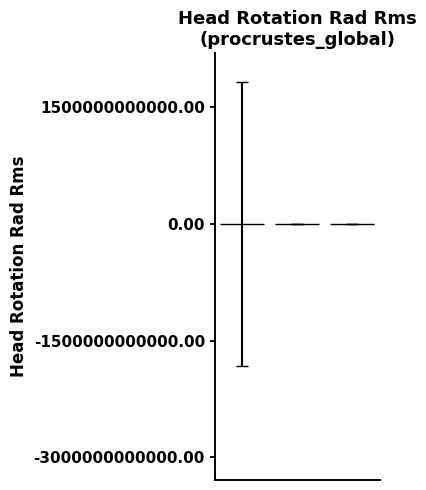

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for blink_aperture_mean_abs_vel:
  H: 0.177
  L: 0.169
  M: 0.183

=== procrustes_global_blink_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1076.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9650 -0.6576  0.0028  0.5402  4.7921 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0003845 0.01961 
 Residual                   0.0010734 0.03276 
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   1.792e-01  1.219e-02  1.962e+00  14.692  0.00497 **
condition.L   1.113e-02  6.550e-03  2.763e+02   1.699  0.09037 . 
condition.Q  -1.649e-02  6.590e-03  2.756e+02  -2.502  0.01292 * 
window_index  9.808e-05  3.832e-05  2.760e

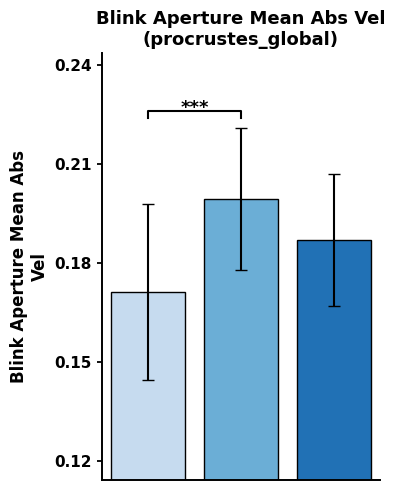

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for blink_aperture_mean_abs_acc:
  H: 6.343
  L: 6.073
  M: 6.480

=== procrustes_global_blink_aperture_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 996.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5931 -0.5832 -0.0551  0.3373  5.8551 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.3586   0.5988  
 Residual                   1.9197   1.3855  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)    6.385182   0.394089   1.872553  16.202  0.00499 **
condition.L    0.411655   0.276681 276.881900   1.488  0.13793   
condition.Q   -0.456232   0.277312 265.907283  -1.645  0.10111   
window_index   0.003922   0.001613 267.250492  

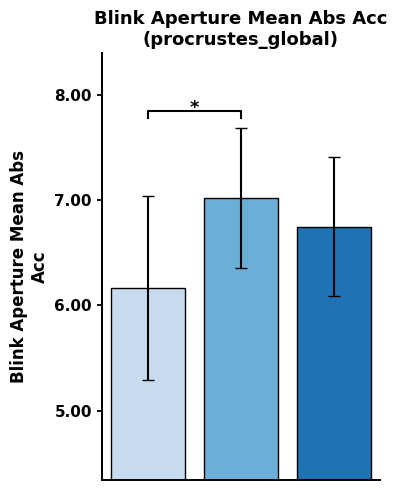

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for blink_aperture_rms:
  H: 0.042
  L: 0.044
  M: 0.051

=== procrustes_global_blink_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1661.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3031 -0.7214  0.0185  0.6555  3.4203 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 7.528e-05 0.008677
 Residual                   1.296e-04 0.011383
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   4.816e-02  5.254e-03  1.993e+00   9.165 0.011828 *  
condition.L   1.697e-03  2.277e-03  2.759e+02   0.745 0.456717    
condition.Q  -8.705e-03  2.295e-03  2.769e+02  -3.793 0.000183 ***
window_index  5.204e-05  1.334e-05  2.770e+02   3.901 0.

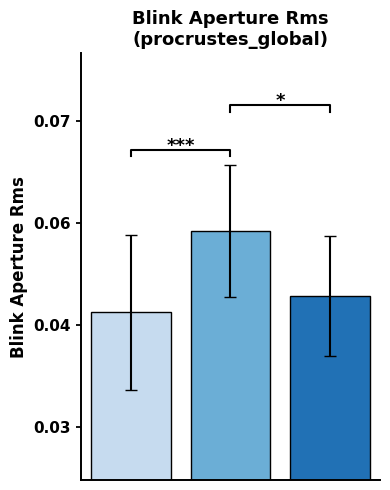

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for mouth_aperture_mean_abs_vel:
  H: 0.162
  L: 0.102
  M: 0.095

=== procrustes_global_mouth_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -918

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0747 -0.6423 -0.1063  0.3119  3.9699 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0002512 0.01585 
 Residual                   0.0017982 0.04241 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  1.241e-01  1.083e-02 2.199e+00  11.456 0.005298 ** 
condition.L  5.462e-02  8.468e-03 2.720e+02   6.450 5.09e-10 ***
condition.Q  2.849e-02  8.462e-03 2.550e+02   3.367 0.000877 ***
window_index 2.036e-04  4.979e-05 2.566e+02   4.0

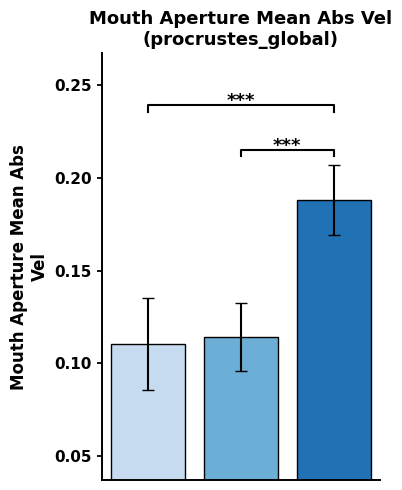

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for mouth_aperture_mean_abs_acc:
  H: 6.456
  L: 4.781
  M: 4.703

=== procrustes_global_mouth_aperture_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 987.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0683 -0.6652 -0.0895  0.4456  3.6206 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.8551   0.9247  
 Residual                   1.9668   1.4024  
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  5.678e+00  5.690e-01 2.093e+00   9.979  0.00849 ** 
condition.L  1.767e+00  2.807e-01 2.711e+02   6.296 1.23e-09 ***
condition.Q  7.050e-01  2.824e-01 2.715e+02   2.496  0.01314 *  
window_index 9.494e-03  1.660e-03 2.718e+02   5.718

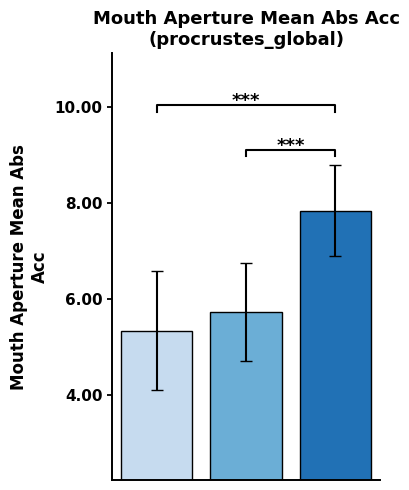

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for mouth_aperture_rms:
  H: 0.033
  L: 0.016
  M: 0.011

=== procrustes_global_mouth_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1606.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6603 -0.7699 -0.3403  0.5213  3.4964 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 7.030e-06 0.002651
 Residual                   1.437e-04 0.011988
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   1.883e-02  2.190e-03  1.543e+00   8.598   0.0275 *  
condition.L   1.210e-02  2.384e-03  2.675e+02   5.076 7.24e-07 ***
condition.Q   1.062e-02  2.356e-03  1.725e+02   4.508 1.21e-05 ***
window_index -2.264e-06  1.386e-05  1.639e+02  -0.163   

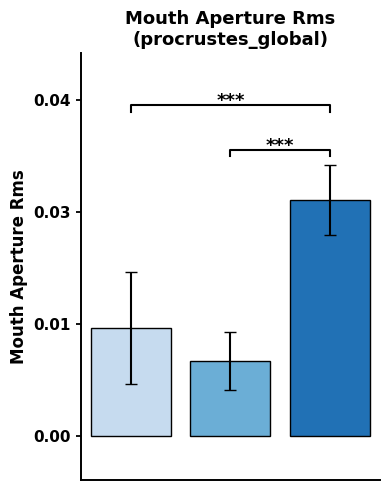

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dx_mean_abs_vel:
  H: 0.050
  L: 0.053
  M: 0.053

=== procrustes_global_pupil_dx_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1587.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1843 -0.3980 -0.1482  0.0759  6.1665 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0000255 0.00505 
 Residual                   0.0001707 0.01307 
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   5.333e-02  3.412e-03  1.884e+00  15.628   0.0052 **
condition.L  -2.129e-04  2.608e-03  2.770e+02  -0.082   0.9350   
condition.Q  -2.544e-03  2.609e-03  2.589e+02  -0.975   0.3305   
window_index  3.193e-05  1.518e-05  2.601e+02   2.104 

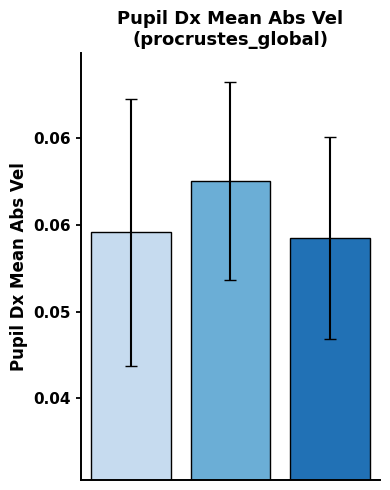

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dx_mean_abs_acc:
  H: 1.995
  L: 2.126
  M: 2.108

=== procrustes_global_pupil_dx_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 641.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9054 -0.3377 -0.1602  0.0207  6.6063 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.0519   0.2278  
 Residual                   0.5344   0.7310  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   2.131e+00  1.639e-01  1.722e+00  13.005   0.0101 *
condition.L  -3.733e-03  1.457e-01  2.766e+02  -0.026   0.9796  
condition.Q  -9.501e-02  1.452e-01  2.341e+02  -0.654   0.5136  
window_index  1.486e-03  8.447e-04  2.331e+02   1.759   0.0799 

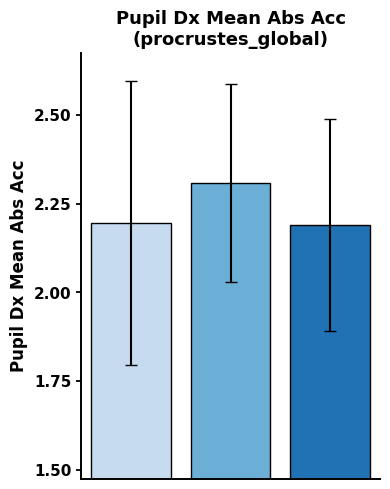

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for pupil_dx_rms:
  H: 0.005
  L: 0.006
  M: 0.006

=== procrustes_global_pupil_dx_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1992.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.3977 -0.2629 -0.2115 -0.1390  5.6638 

Random effects:
 Groups         Name        Variance  Std.Dev. 
 participant_id (Intercept) 4.782e-21 6.915e-11
 Residual                   4.004e-05 6.328e-03
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   5.542e-03  7.124e-04  2.770e+02   7.779 1.45e-13 ***
condition.L  -7.715e-04  1.240e-03  2.770e+02  -0.622    0.534    
condition.Q  -8.284e-04  1.184e-03  2.770e+02  -0.700    0.485    
window_index  2.763e-06  6.806e-06  2.770e+02   0.406    0.685   

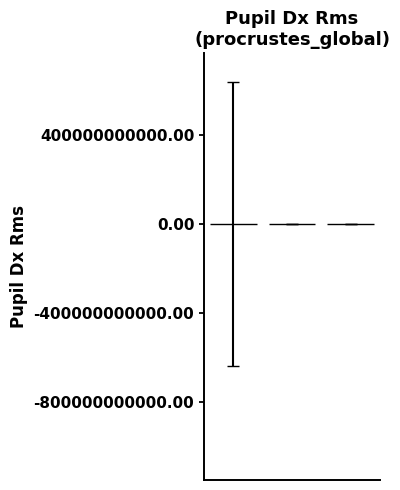

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dy_mean_abs_vel:
  H: 0.103
  L: 0.102
  M: 0.106

=== procrustes_global_pupil_dy_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1256

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4320 -0.4914 -0.1376  0.2373  5.8839 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 2.268e-05 0.004762
 Residual                   5.683e-04 0.023838
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   1.033e-01  4.117e-03  1.307e+00  25.099   0.0103 *
condition.L   1.981e-03  4.733e-03  2.680e+02   0.418   0.6759  
condition.Q  -5.455e-03  4.666e-03  1.449e+02  -1.169   0.2444  
window_index  2.955e-05  2.712e-05  1.282e+02   1.090   0.27

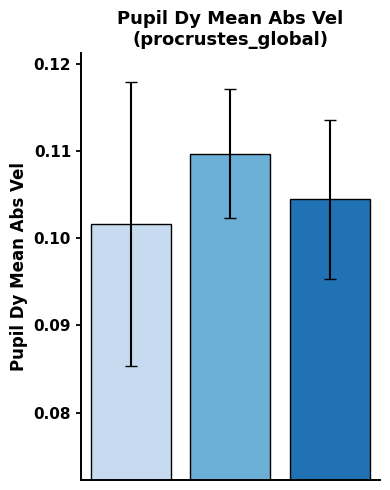

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dy_mean_abs_acc:
  H: 4.031
  L: 4.047
  M: 4.149

=== procrustes_global_pupil_dy_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 907.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0565 -0.4059 -0.1415  0.1349  6.4759 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.02006  0.1416  
 Residual                   1.40756  1.1864  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)    4.039218   0.166090   0.686832  24.319   0.0695 .
condition.L    0.055717   0.234297 222.143740   0.238   0.8123  
condition.Q   -0.166599   0.227928  54.787678  -0.731   0.4679  
window_index   0.001362   0.001320  37.983151   1.031   0.3089 

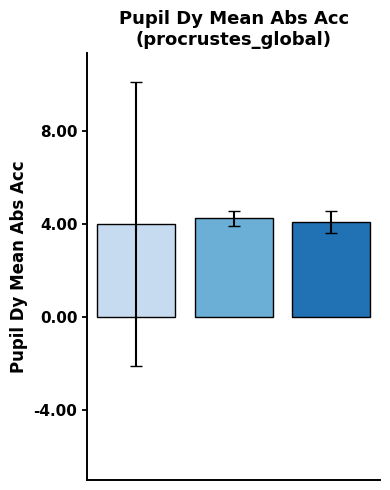

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dy_rms:
  H: 0.012
  L: 0.013
  M: 0.014

=== procrustes_global_pupil_dy_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1973.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9875 -0.4396 -0.1472  0.0869  5.6283 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 1.473e-06 0.001214
 Residual                   4.261e-05 0.006528
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   1.297e-02  1.088e-03  1.014e+00  11.921   0.0516 .
condition.L  -2.998e-05  1.295e-03  2.621e+02  -0.023   0.9815  
condition.Q  -1.687e-03  1.274e-03  1.163e+02  -1.324   0.1882  
window_index  1.222e-05  7.405e-06  9.839e+01   1.650   0.1022  
---
Signif.

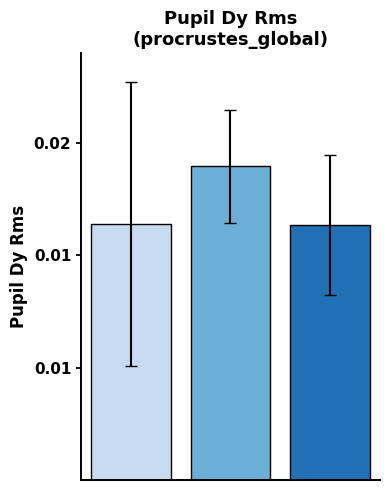

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for pupil_metric_mean_abs_vel:
  H: 0.077
  L: 0.077
  M: 0.079

=== procrustes_global_pupil_metric_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1293.9

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.117 -0.436 -0.209  0.086  6.143 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0000000 0.00000 
 Residual                   0.0004984 0.02232 
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   7.699e-02  2.513e-03  2.770e+02  30.633   <2e-16 ***
condition.L   1.028e-03  4.374e-03  2.770e+02   0.235    0.814    
condition.Q  -2.047e-03  4.177e-03  2.770e+02  -0.490    0.624    
window_index  1.909e-05  2.401e-05  2.770e+02   0.79

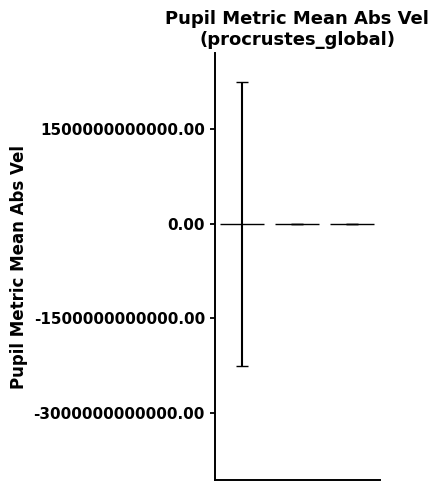

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for pupil_metric_mean_abs_acc:
  H: 3.186
  L: 3.258
  M: 3.296

=== procrustes_global_pupil_metric_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 962.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8453 -0.3676 -0.1718  0.0157  6.4845 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.000    0.000   
 Residual                   1.718    1.311   
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    3.206973   0.147547 277.000000  21.735   <2e-16 ***
condition.L    0.013940   0.256767 277.000000   0.054    0.957    
condition.Q   -0.098396   0.245242 277.000000  -0.401    0.689    
window_index   0.001296   0.001410 277.000000  

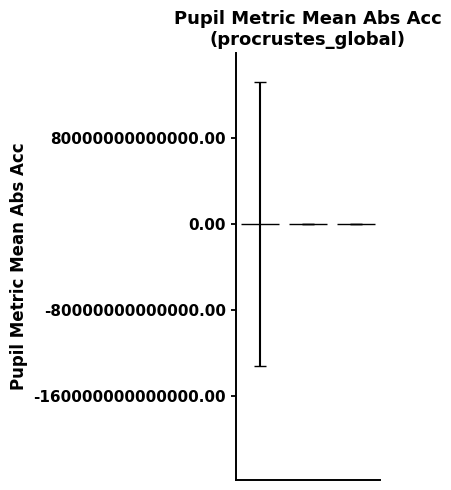

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for pupil_metric_rms:
  H: 0.008
  L: 0.009
  M: 0.010

=== procrustes_global_pupil_metric_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1805.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5511 -0.2930 -0.1993 -0.0958  5.2602 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 5.903e-24 2.43e-12
 Residual                   7.850e-05 8.86e-03
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   8.742e-03  9.975e-04  2.770e+02   8.764   <2e-16 ***
condition.L  -8.759e-04  1.736e-03  2.770e+02  -0.505    0.614    
condition.Q  -1.248e-03  1.658e-03  2.770e+02  -0.753    0.452    
window_index  5.610e-06  9.530e-06  2.770e+02   0.589    0.5

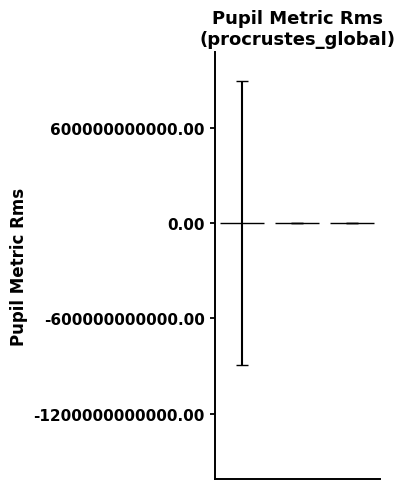

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_tx_mean_abs_vel:
  H: 0.717
  L: 0.821
  M: 0.840

=== procrustes_global_head_tx_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 415.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8624 -0.3642 -0.1584  0.0414  6.4153 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.02967  0.1722  
 Residual                   0.23633  0.4861  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   8.231e-01  1.191e-01  1.759e+00   6.909   0.0281 *
condition.L  -2.858e-02  9.698e-02  2.770e+02  -0.295   0.7685  
condition.Q  -1.171e-01  9.688e-02  2.498e+02  -1.208   0.2280  
window_index  7.687e-04  5.636e-04  2.506e+02   1.364   0.1738  


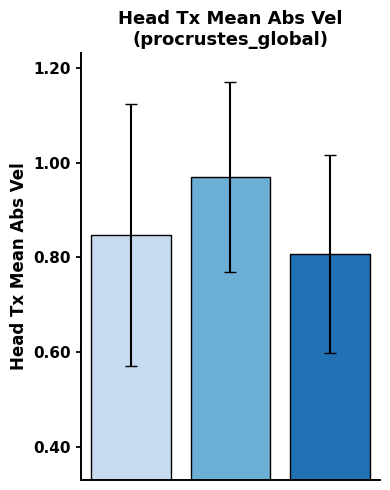

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_tx_mean_abs_acc:
  H: 21.766
  L: 28.996
  M: 29.620

=== procrustes_global_head_tx_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 2655.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5989 -0.2911 -0.1617 -0.0568  6.0742 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)  11.93    3.454  
 Residual                   772.53   27.794  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)
(Intercept)   26.53964    3.94200   0.43797   6.733    0.283
condition.L   -3.54614    5.49117 203.22817  -0.646    0.519
condition.Q   -4.81492    5.34709  39.02960  -0.900    0.373
window_index   0.02974    0.03098  26.77977   0.960    0.346

Correlation of 

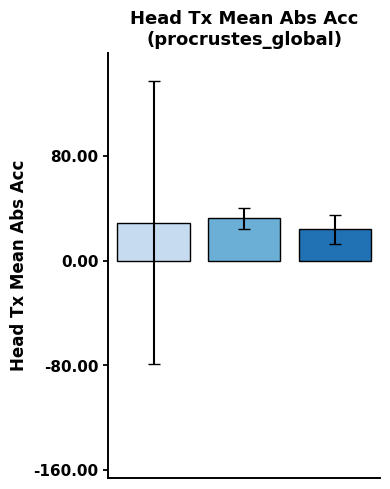

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_tx_rms:
  H: 0.252
  L: 0.307
  M: 0.306

=== procrustes_global_head_tx_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 22.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9528 -0.4283 -0.2116  0.0547  5.6658 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.007379 0.0859  
 Residual                   0.057077 0.2389  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   3.051e-01  5.917e-02  1.775e+00   5.156   0.0454 *
condition.L  -1.155e-02  4.766e-02  2.770e+02  -0.242   0.8088  
condition.Q  -4.992e-02  4.763e-02  2.515e+02  -1.048   0.2956  
window_index  4.726e-04  2.771e-04  2.524e+02   1.706   0.0893 .
---
Signif. codes: 

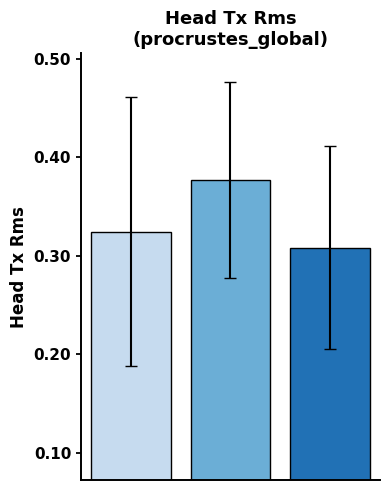

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_ty_mean_abs_vel:
  H: 0.864
  L: 0.982
  M: 1.067

=== procrustes_global_head_ty_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 507.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0482 -0.4336 -0.1338  0.1511  6.6327 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.08141  0.2853  
 Residual                   0.32764  0.5724  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   1.046e+00  1.825e-01  1.942e+00   5.730  0.03114 * 
condition.L   2.261e-02  1.144e-01  2.766e+02   0.198  0.84344   
condition.Q  -1.974e-01  1.148e-01  2.719e+02  -1.718  0.08685 . 
window_index  1.759e-03  6.679e-04  2.729e+02   2.633  0.0089

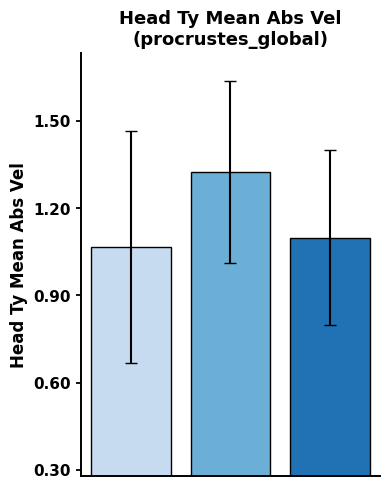

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_ty_mean_abs_acc:
  H: 24.836
  L: 34.913
  M: 37.123

=== procrustes_global_head_ty_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 2739.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7035 -0.3493 -0.1798  0.0173  6.6072 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)  121.3   11.02   
 Residual                   1037.9   32.22   
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)  
(Intercept)   34.99346    7.69839   1.79729   4.546   0.0549 .
condition.L   -2.58450    6.42512 276.92475  -0.402   0.6878  
condition.Q   -8.71084    6.41473 246.63417  -1.358   0.1757  
window_index   0.07596    0.03732 247.08122   2.036   0.0429 *
---
Si

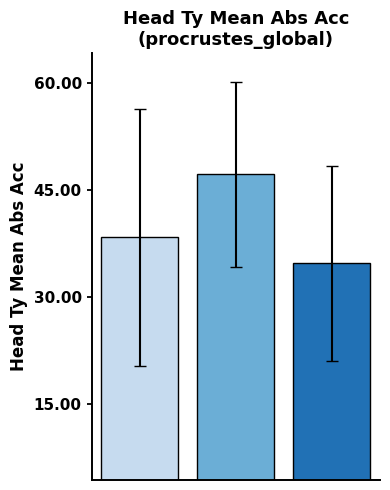

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_ty_rms:
  H: 0.293
  L: 0.353
  M: 0.315

=== procrustes_global_head_ty_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 171.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8556 -0.3864 -0.2089 -0.0061  5.8055 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.00689  0.08301 
 Residual                   0.09805  0.31313 
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   3.267e-01  6.329e-02  1.483e+00   5.162   0.0638 .
condition.L  -6.198e-03  6.233e-02  2.752e+02  -0.099   0.9209  
condition.Q  -2.583e-02  6.190e-02  2.022e+02  -0.417   0.6769  
window_index  6.548e-04  3.600e-04  1.962e+02   1.819   0.0705 .
---
Signif. codes:

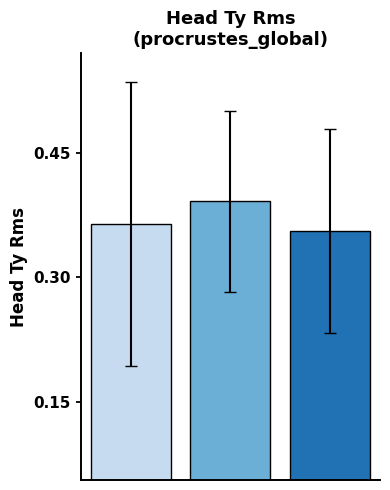

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_scale_mean_abs_vel:
  H: 0.098
  L: 0.103
  M: 0.107

=== procrustes_global_head_scale_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -911.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9838 -0.3464 -0.1220  0.1020  7.0243 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0001164 0.01079 
 Residual                   0.0019690 0.04437 
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   1.033e-01  8.520e-03  1.370e+00  12.124   0.0232 *
condition.L   9.959e-04  8.827e-03  2.736e+02   0.113   0.9103  
condition.Q  -9.324e-03  8.747e-03  1.821e+02  -1.066   0.2878  
window_index  7.676e-05  5.087e-05  1.727e+02   1.509  

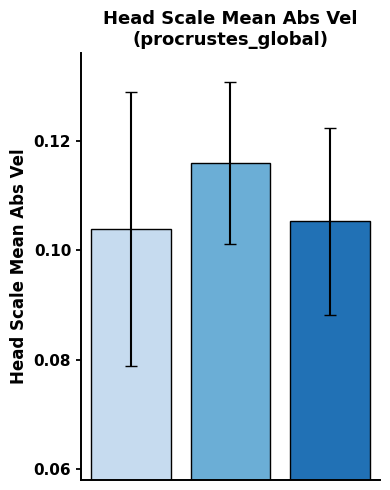

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_scale_mean_abs_acc:
  H: 3.094
  L: 3.585
  M: 3.580

=== procrustes_global_head_scale_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1288.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6655 -0.2622 -0.1417 -0.0020  7.2460 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.216    0.4648  
 Residual                   5.538    2.3533  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)    3.484824   0.404056   1.317874   8.625   0.0405 *
condition.L   -0.099234   0.467171 267.663721  -0.212   0.8319  
condition.Q   -0.314661   0.460470 143.582217  -0.683   0.4955  
window_index   0.004331   0.002676 126.605446   1.618   0.

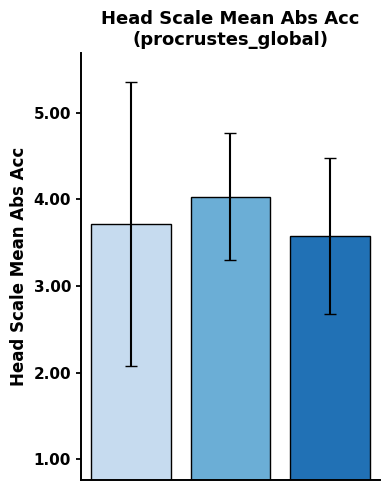

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_scale_rms:
  H: 0.027
  L: 0.030
  M: 0.030

=== procrustes_global_head_scale_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1321

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0490 -0.4108 -0.2031  0.0415  5.9933 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 1.423e-05 0.003773
 Residual                   4.498e-04 0.021208
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   2.833e-02  3.464e-03  9.118e-01   8.180   0.0920 .
condition.L   3.586e-04  4.206e-03  2.581e+02   0.085   0.9321  
condition.Q  -3.392e-03  4.134e-03  1.032e+02  -0.820   0.4139  
window_index  4.662e-05  2.401e-05  8.510e+01   1.941   0.0555 .
---
Signi

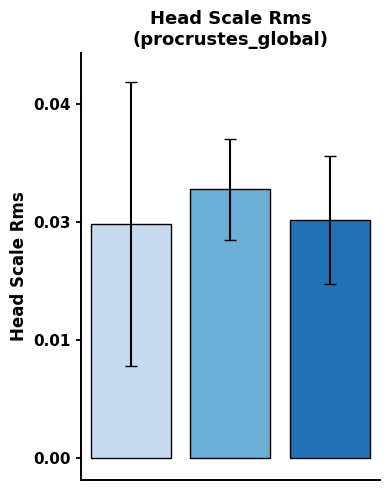

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_motion_mag_mean_abs_vel:
  H: 1.599
  L: 1.918
  M: 2.131

=== procrustes_global_head_motion_mag_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 941.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0054 -0.4091 -0.1642  0.0914  6.3248 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.3605   0.6004  
 Residual                   1.5711   1.2535  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)    2.076776   0.386986   1.997772   5.367  0.03309 * 
condition.L    0.062265   0.250418 276.721241   0.249  0.80382   
condition.Q   -0.415258   0.251336 270.843647  -1.652  0.09965 . 
window_index   0.004684   0.001462 271.908498

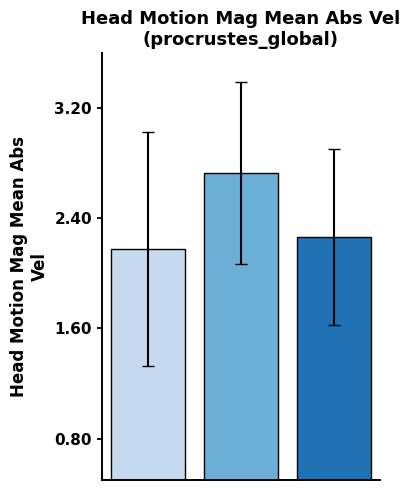

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_motion_mag_mean_abs_acc:
  H: 52.086
  L: 74.321
  M: 80.156

=== procrustes_global_head_motion_mag_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 3214

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6619 -0.3288 -0.1818 -0.0365  6.0328 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)  376.8   19.41   
 Residual                   5780.1   76.03   
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
             Estimate Std. Error       df t value Pr(>|t|)  
(Intercept)   72.7426    15.0231   1.5762   4.842   0.0627 .
condition.L   -6.5600    15.1295 274.7826  -0.434   0.6649  
condition.Q  -18.6679    15.0103 199.1395  -1.244   0.2151  
window_index   0.1565     0.0873 191.9999   1.793   0.0746 .
--

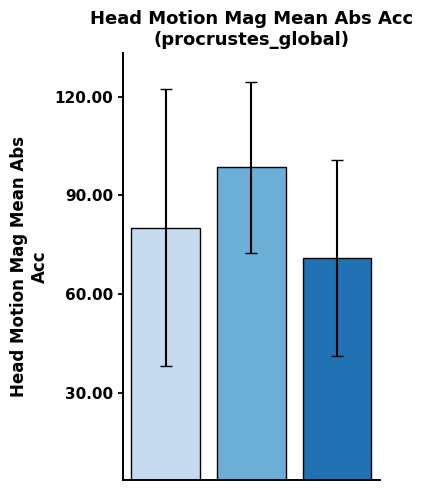

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_motion_mag_rms:
  H: 0.417
  L: 0.539
  M: 0.639

=== procrustes_global_head_motion_mag_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 563.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6801 -0.4007 -0.2339  0.0532  6.2955 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.008447 0.09191 
 Residual                   0.405440 0.63674 
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)
(Intercept)   5.232e-01  9.525e-02  6.580e-01   5.493    0.202
condition.L  -2.765e-02  1.260e-01  2.348e+02  -0.219    0.826
condition.Q  -1.720e-01  1.232e-01  6.371e+01  -1.397    0.167
window_index  1.107e-03  7.144e-04  4.715e+01   1.550    0.128

Correlation

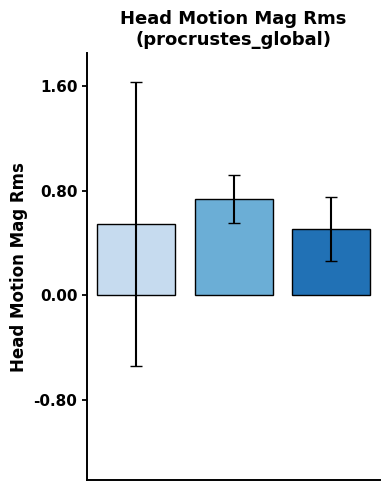

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



Analyzing procrustes_participant normalization method...
Means for head_rotation_rad_mean_abs_vel:
  H: 0.199
  L: 0.193
  M: 0.197

=== procrustes_participant_head_rotation_rad_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -742.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2230 -0.3751 -0.1356  0.1457  6.7932 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0003636 0.01907 
 Residual                   0.0034334 0.05860 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   1.887e-01  1.357e-02  1.856e+00  13.908  0.00685 **
condition.L  -1.933e-03  1.169e-02  2.718e+02  -0.165  0.86879   
condition.Q   6.225e-04  1.165e-02  2.38

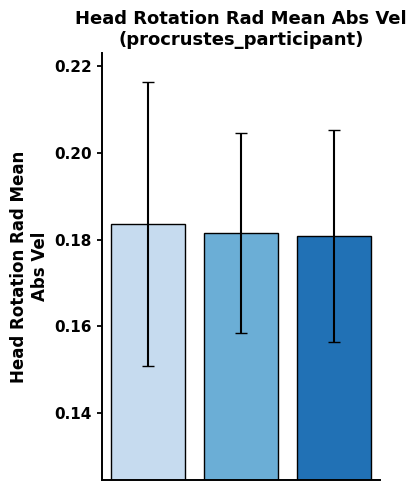

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_rotation_rad_mean_abs_acc:
  H: 7.513
  L: 7.668
  M: 8.157

=== procrustes_participant_head_rotation_rad_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1631.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6127 -0.2694 -0.1449 -0.0094  7.2803 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)  0.6388  0.7993  
 Residual                   21.2970  4.6149  
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)    7.522425   0.746672   2.306515  10.075   0.0059 **
condition.L   -0.475295   0.915649 264.432032  -0.519   0.6041   
condition.Q   -0.552240   0.898888 162.822775  -0.614   0.5398   
window_index  -0.005744   0.005284 

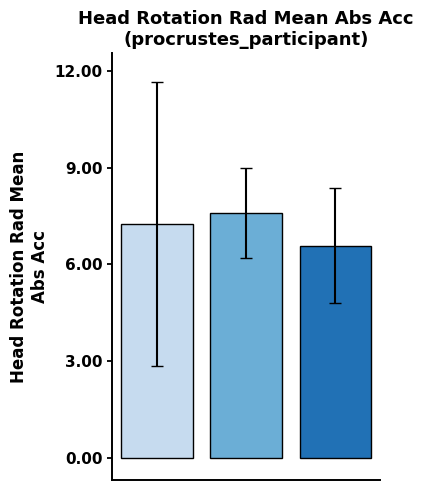

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_rotation_rad_rms:
  H: 0.033
  L: 0.036
  M: 0.035

=== procrustes_participant_head_rotation_rad_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1247.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7258 -0.3204 -0.1711  0.0106  6.8626 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0000000 0.00000 
 Residual                   0.0005408 0.02325 
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   3.448e-02  2.621e-03  2.720e+02  13.154   <2e-16 ***
condition.L  -2.242e-03  4.561e-03  2.720e+02  -0.491    0.624    
condition.Q  -4.063e-04  4.354e-03  2.720e+02  -0.093    0.926    
window_index -2.471e-06  2.538e-05  2.720e+02

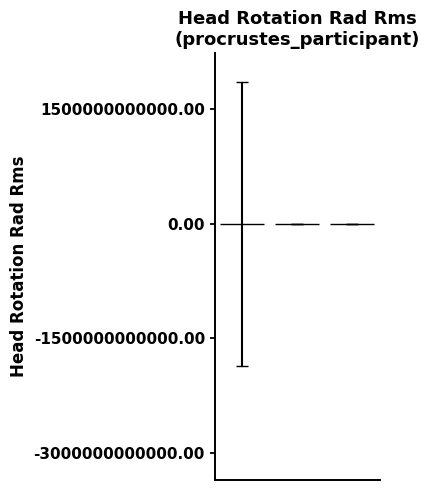

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for blink_aperture_mean_abs_vel:
  H: 0.186
  L: 0.168
  M: 0.188

=== procrustes_participant_blink_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1102.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8347 -0.7121  0.0169  0.5516  3.7508 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0001025 0.01012 
 Residual                   0.0009855 0.03139 
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   1.754e-01  7.203e-03  2.623e+00  24.354 0.000365 ***
condition.L   1.264e-02  6.259e-03  2.769e+02   2.020 0.044328 *  
condition.Q  -1.591e-02  6.241e-03  2.505e+02  -2.550 0.011380 *  
window_index  1.631e-05  3.631e-0

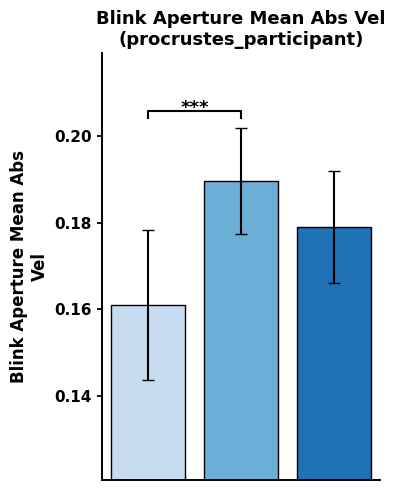

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for blink_aperture_mean_abs_acc:
  H: 6.663
  L: 6.023
  M: 6.641

=== procrustes_participant_blink_aperture_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 952.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7001 -0.6570 -0.0757  0.4449  4.9769 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.06982  0.2642  
 Residual                   1.64932  1.2843  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    6.293512   0.225115   2.827861  27.957 0.000153 ***
condition.L    0.488218   0.255057 273.255846   1.914 0.056645 .  
condition.Q   -0.421865   0.251670 199.116432  -1.676 0.095257 .  
window_index   0.001217   0.001463 185

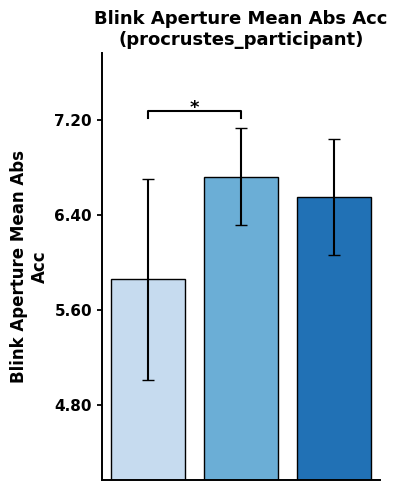

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for blink_aperture_rms:
  H: 0.044
  L: 0.044
  M: 0.052

=== procrustes_participant_blink_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1695.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.16536 -0.75286  0.06743  0.60700  2.53136 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 1.226e-05 0.003502
 Residual                   1.156e-04 0.010754
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   4.638e-02  2.484e-03  1.749e+00  18.673 0.005110 ** 
condition.L   1.782e-03  2.144e-03  2.768e+02   0.831 0.406654    
condition.Q  -8.428e-03  2.139e-03  2.402e+02  -3.941 0.000107 ***
window_index  2.827e-05  1.244e-05  2.400

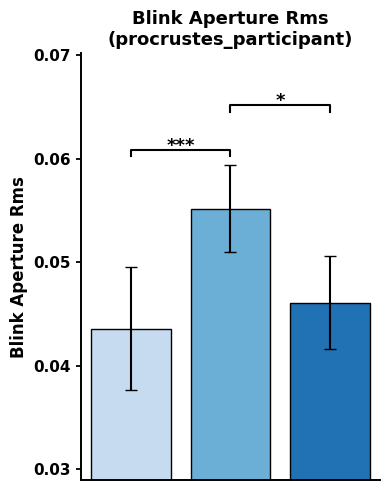

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for mouth_aperture_mean_abs_vel:
  H: 0.170
  L: 0.101
  M: 0.097

=== procrustes_participant_mouth_aperture_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -897.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0949 -0.6106 -0.1172  0.2578  4.0246 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0000205 0.004528
 Residual                   0.0019550 0.044216
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  1.200e-01  5.932e-03 2.185e+00  20.227  0.00158 ** 
condition.L  5.649e-02  8.728e-03 2.506e+02   6.473 5.03e-10 ***
condition.Q  2.822e-02  8.456e-03 1.132e+02   3.338  0.00114 ** 
window_index 1.465e-04  4.956e-05 8.884e+0

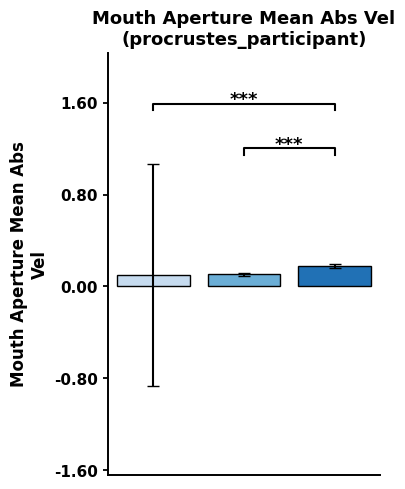

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for mouth_aperture_mean_abs_acc:
  H: 6.776
  L: 4.736
  M: 4.806

=== procrustes_participant_mouth_aperture_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 995.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9349 -0.6140 -0.0946  0.3749  3.7797 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.1515   0.3892  
 Residual                   2.0513   1.4322  
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  5.483e+00  2.948e-01 2.545e+00  18.598  0.00087 ***
condition.L  1.836e+00  2.854e-01 2.712e+02   6.435 5.58e-10 ***
condition.Q  7.314e-01  2.834e-01 2.285e+02   2.581  0.01048 *  
window_index 6.937e-03  1.667e-03 2.268e+02   

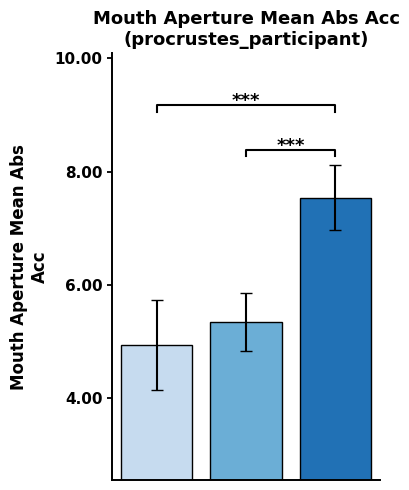

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for mouth_aperture_rms:
  H: 0.035
  L: 0.016
  M: 0.012

=== procrustes_participant_mouth_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1578.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6578 -0.7898 -0.3309  0.5144  3.5449 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 1.589e-05 0.003987
 Residual                   1.590e-04 0.012610
Number of obs: 276, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   1.881e-02  2.863e-03  1.869e+00   6.572   0.0265 *  
condition.L   1.270e-02  2.515e-03  2.718e+02   5.049 8.16e-07 ***
condition.Q   1.106e-02  2.506e-03  2.358e+02   4.413 1.55e-05 ***
window_index -7.611e-06  1.475e-05  2.365e+02  -0.5

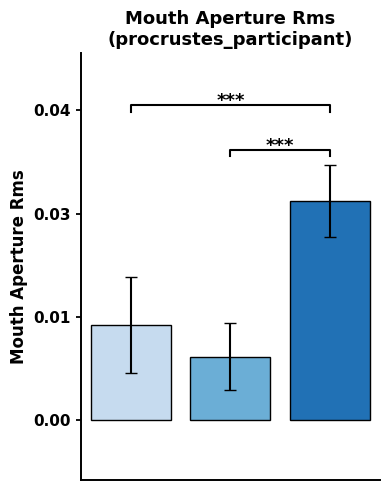

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dx_mean_abs_vel:
  H: 0.052
  L: 0.052
  M: 0.054

=== procrustes_participant_pupil_dx_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1659.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0649 -0.4730 -0.1682  0.1334  5.0903 

Random effects:
 Groups         Name        Variance  Std.Dev. 
 participant_id (Intercept) 8.134e-07 0.0009019
 Residual                   1.332e-04 0.0115406
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   5.259e-02  1.454e-03  2.127e+00  36.175 0.000528 ***
condition.L   3.825e-04  2.271e-03  2.466e+02   0.168 0.866370    
condition.Q  -2.033e-03  2.191e-03  1.010e+02  -0.928 0.355648    
window_index  4.963e-06  1.265e-05  6.965e

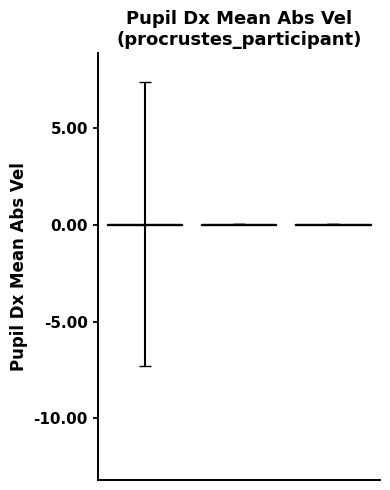

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for pupil_dx_mean_abs_acc:
  H: 2.104
  L: 2.097
  M: 2.161

=== procrustes_participant_pupil_dx_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 555.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8326 -0.4093 -0.1697  0.0488  5.8326 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.000    0.0000  
 Residual                   0.396    0.6293  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   2.107e+00  7.085e-02  2.770e+02  29.740   <2e-16 ***
condition.L   2.682e-02  1.233e-01  2.770e+02   0.218    0.828    
condition.Q  -6.199e-02  1.178e-01  2.770e+02  -0.526    0.599    
window_index  4.364e-04  6.769e-04  2.770e+02   0.

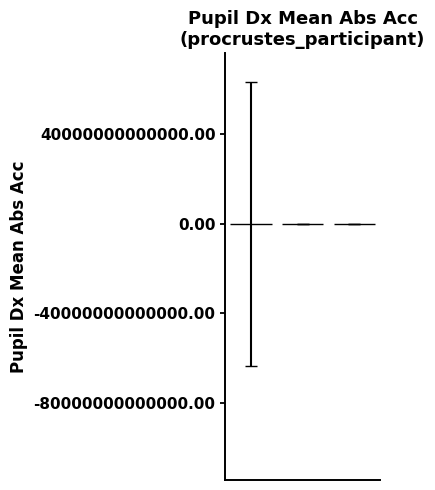

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dx_rms:
  H: 0.005
  L: 0.006
  M: 0.006

=== procrustes_participant_pupil_dx_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -2005.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.3963 -0.2590 -0.1974 -0.1326  6.2527 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 2.088e-07 0.000457
 Residual                   3.815e-05 0.006177
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   5.605e-03  7.704e-04  1.962e+00   7.275   0.0194 *
condition.L  -7.125e-04  1.215e-03  2.434e+02  -0.586   0.5581  
condition.Q  -9.603e-04  1.171e-03  9.455e+01  -0.820   0.4142  
window_index  2.215e-08  6.760e-06  6.402e+01   0.003   0.9974  
---
Si

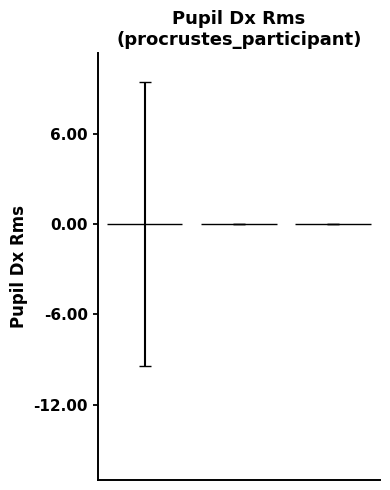

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dy_mean_abs_vel:
  H: 0.108
  L: 0.102
  M: 0.109

=== procrustes_participant_pupil_dy_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1289.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4729 -0.6003 -0.1797  0.3723  5.0781 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 4.025e-05 0.006344
 Residual                   5.024e-04 0.022415
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   1.027e-01  4.719e-03  2.892e+00  21.754 0.000269 ***
condition.L   3.123e-03  4.464e-03  2.764e+02   0.699 0.484840    
condition.Q  -6.509e-03  4.440e-03  2.404e+02  -1.466 0.143915    
window_index -1.355e-05  2.583e-05  2.379e+02

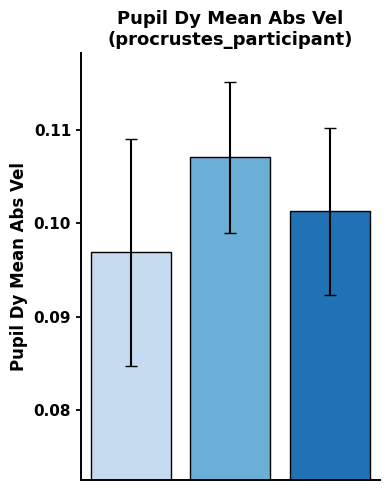

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_dy_mean_abs_acc:
  H: 4.227
  L: 4.014
  M: 4.254

=== procrustes_participant_pupil_dy_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 855.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2359 -0.5349 -0.1670  0.2605  5.8433 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.05574  0.2361  
 Residual                   1.16103  1.0775  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   4.043e+00  1.952e-01  3.015e+00  20.711 0.000239 ***
condition.L   1.121e-01  2.141e-01  2.743e+02   0.524 0.601031    
condition.Q  -2.261e-01  2.116e-01  2.109e+02  -1.068 0.286573    
window_index -2.424e-04  1.230e-03  2.005e+02  -0.

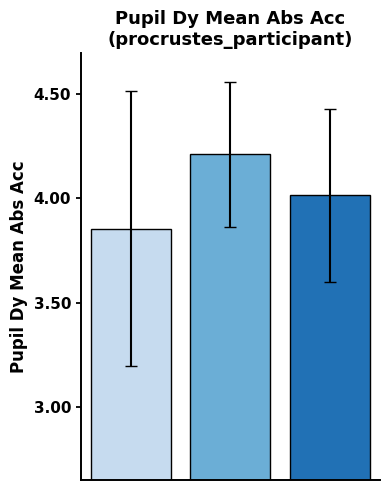

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for pupil_dy_rms:
  H: 0.013
  L: 0.013
  M: 0.014

=== procrustes_participant_pupil_dy_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -2019.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1138 -0.4709 -0.1687  0.1267  5.1051 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.000e+00 0.000000
 Residual                   3.632e-05 0.006027
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   1.298e-02  6.785e-04  2.770e+02  19.136   <2e-16 ***
condition.L   2.348e-04  1.181e-03  2.770e+02   0.199    0.843    
condition.Q  -1.518e-03  1.128e-03  2.770e+02  -1.346    0.179    
window_index  7.673e-06  6.482e-06  2.770e+02   1.184    0.238 

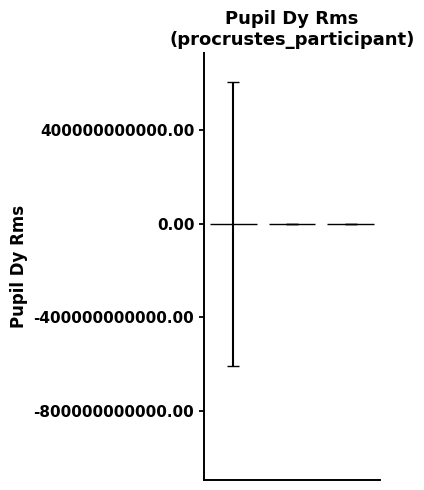

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_metric_mean_abs_vel:
  H: 0.081
  L: 0.076
  M: 0.081

=== procrustes_participant_pupil_metric_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1337

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2904 -0.5383 -0.2016  0.2183  5.3627 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 3.233e-05 0.005686
 Residual                   4.230e-04 0.020568
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   7.624e-02  4.266e-03  2.831e+00  17.870 0.000536 ***
condition.L   1.482e-03  4.096e-03  2.763e+02   0.362 0.717673    
condition.Q  -4.109e-03  4.071e-03  2.371e+02  -1.009 0.313796    
window_index -1.907e-05  2.368e-05  2.3

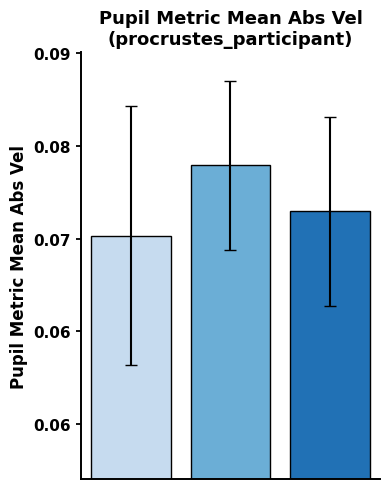

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_metric_mean_abs_acc:
  H: 3.344
  L: 3.226
  M: 3.382

=== procrustes_participant_pupil_metric_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 903.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0226 -0.4346 -0.1985  0.1029  5.7914 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.02558  0.1599  
 Residual                   1.38682  1.1776  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   3.246e+00  1.722e-01  2.764e+00  18.847  0.00053 ***
condition.L   7.360e-02  2.329e-01  2.642e+02   0.316  0.75220    
condition.Q  -1.467e-01  2.273e-01  1.489e+02  -0.646  0.51956    
window_index  9.115e-05  1.318e-03  1.215e

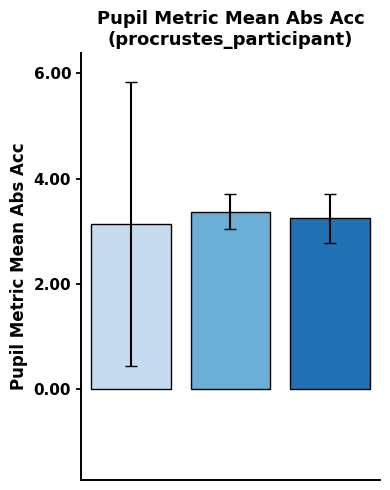

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for pupil_metric_rms:
  H: 0.008
  L: 0.009
  M: 0.010

=== procrustes_participant_pupil_metric_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1833.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6061 -0.3099 -0.2231 -0.0805  5.6023 

Random effects:
 Groups         Name        Variance  Std.Dev. 
 participant_id (Intercept) 4.542e-07 0.0006739
 Residual                   7.092e-05 0.0084217
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   8.876e-03  1.066e-03  1.970e+00   8.330   0.0148 *
condition.L  -7.393e-04  1.657e-03  2.449e+02  -0.446   0.6560  
condition.Q  -1.459e-03  1.599e-03  9.677e+01  -0.912   0.3639  
window_index  1.932e-06  9.237e-06  6.641e+01   0.209   0.83

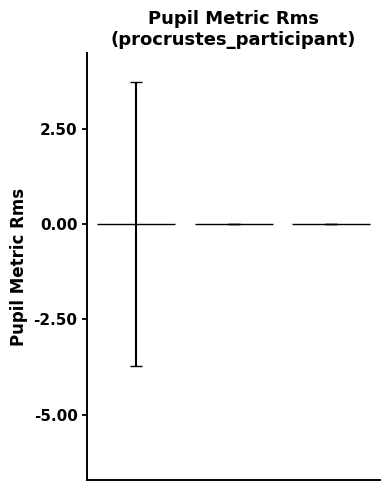

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_tx_mean_abs_vel:
  H: 0.730
  L: 0.805
  M: 0.862

=== procrustes_participant_head_tx_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 390.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8325 -0.3656 -0.1596  0.0311  6.0845 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.003149 0.05611 
 Residual                   0.217680 0.46656 
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)
(Intercept)   7.875e-01  6.547e-02  5.859e-01  12.028    0.146
condition.L  -2.782e-02  9.215e-02  2.154e+02  -0.302    0.763
condition.Q  -1.051e-01  8.966e-02  4.843e+01  -1.173    0.247
window_index  5.107e-04  5.194e-04  3.335e+01   0.983    0.333

Corr

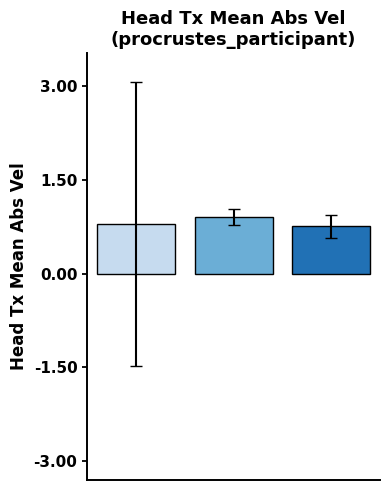

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_tx_mean_abs_acc:
  H: 22.137
  L: 28.478
  M: 30.489

=== procrustes_participant_head_tx_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 2640.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5754 -0.3036 -0.1754 -0.0613  5.8530 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)   0.0     0.00   
 Residual                   735.1    27.11   
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   26.27747    3.05250 277.00000   8.608 5.66e-16 ***
condition.L   -3.24254    5.31211 277.00000  -0.610    0.542    
condition.Q   -4.94710    5.07367 277.00000  -0.975    0.330    
window_index   0.02464    0.02916 277.00000   0.845    0

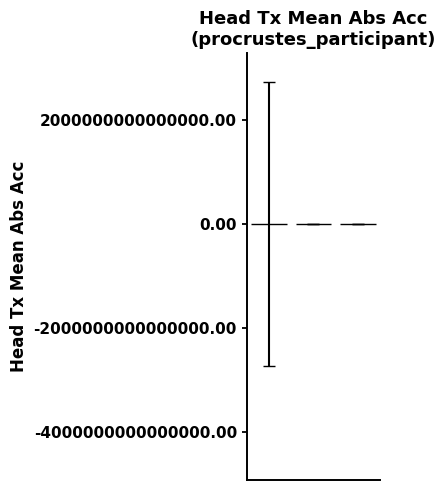

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_tx_rms:
  H: 0.261
  L: 0.300
  M: 0.314

=== procrustes_participant_head_tx_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 29.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8740 -0.4116 -0.2178  0.0528  5.7909 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.00000  0.0000  
 Residual                   0.05916  0.2432  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   2.821e-01  2.738e-02  2.770e+02  10.302   <2e-16 ***
condition.L  -1.165e-02  4.766e-02  2.770e+02  -0.244    0.807    
condition.Q  -3.648e-02  4.552e-02  2.770e+02  -0.801    0.424    
window_index  3.149e-04  2.616e-04  2.770e+02   1.204    0.230    
---


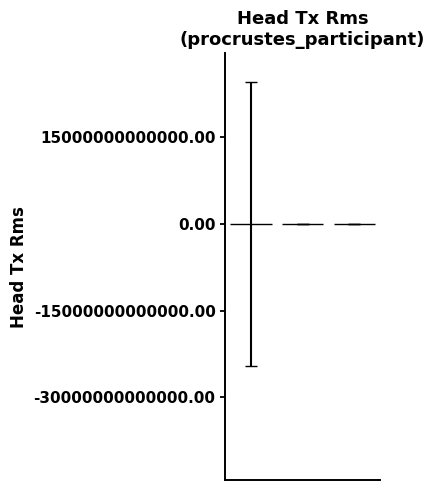

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_ty_mean_abs_vel:
  H: 0.928
  L: 0.971
  M: 1.109

=== procrustes_participant_head_ty_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 523.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0014 -0.4284 -0.1406  0.1307  6.4004 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.01444  0.1202  
 Residual                   0.35040  0.5919  
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   9.921e-01  1.030e-01  1.139e+00   9.628   0.0496 *
condition.L   2.553e-02  1.175e-01  2.673e+02   0.217   0.8282  
condition.Q  -1.909e-01  1.159e-01  1.379e+02  -1.646   0.1020  
window_index  1.083e-03  6.739e-04  1.218e+02   1.607   0.11

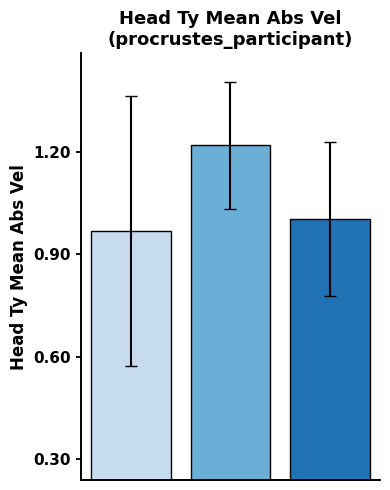

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_ty_mean_abs_acc:
  H: 26.622
  L: 34.242
  M: 38.578

=== procrustes_participant_head_ty_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 2758.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6562 -0.3424 -0.1793 -0.0036  6.6012 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)    0      0.00   
 Residual                   1123     33.51   
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   31.63964    3.77316 277.00000   8.385  2.6e-15 ***
condition.L   -2.91779    6.56623 277.00000  -0.444    0.657    
condition.Q   -8.07694    6.27151 277.00000  -1.288    0.199    
window_index   0.04905    0.03605 277.00000   1.361    0

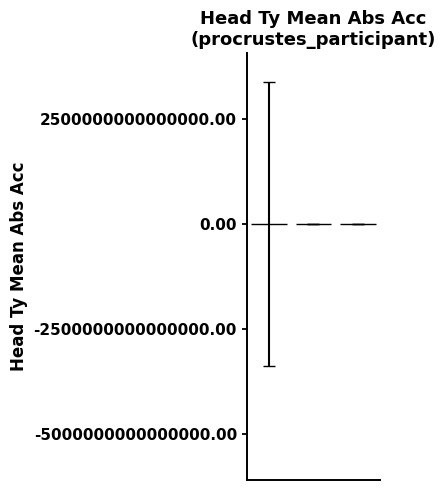

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_ty_rms:
  H: 0.311
  L: 0.352
  M: 0.324

=== procrustes_participant_head_ty_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 201.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7793 -0.3639 -0.1880 -0.0063  6.5619 

Random effects:
 Groups         Name        Variance  Std.Dev. 
 participant_id (Intercept) 3.966e-19 6.298e-10
 Residual                   1.103e-01 3.321e-01
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   3.122e-01  3.738e-02  2.770e+02   8.351 3.27e-15 ***
condition.L  -1.275e-03  6.506e-02  2.770e+02  -0.020    0.984    
condition.Q  -9.949e-03  6.214e-02  2.770e+02  -0.160    0.873    
window_index  5.547e-04  3.572e-04  2.770e+02   1.553    0.122  

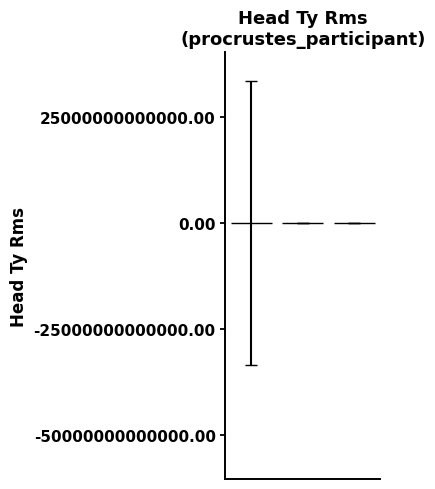

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for head_scale_mean_abs_vel:
  H: 0.102
  L: 0.101
  M: 0.109

=== procrustes_participant_head_scale_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -985.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1736 -0.4251 -0.1342  0.1472  6.6899 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 2.673e-06 0.001635
 Residual                   1.518e-03 0.038968
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)   1.029e-01  4.552e-03  1.063e+00  22.604   0.0235 *
condition.L   2.728e-03  7.646e-03  2.124e+02   0.357   0.7216  
condition.Q  -7.628e-03  7.327e-03  5.543e+01  -1.041   0.3024  
window_index  4.302e-05  4.219e-05  3.346e+01   1.

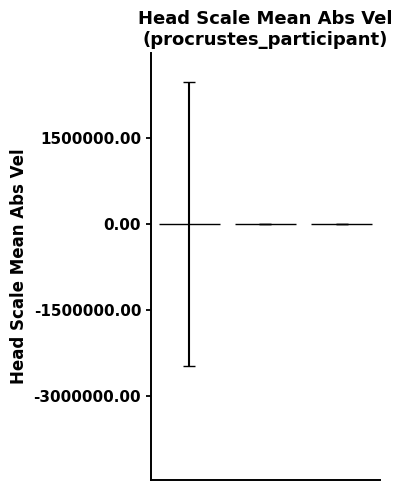

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_scale_mean_abs_acc:
  H: 3.228
  L: 3.519
  M: 3.666

=== procrustes_participant_head_scale_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 1204.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8028 -0.3093 -0.1446  0.0234  7.0743 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.000    0.00    
 Residual                   4.122    2.03    
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    3.390362   0.228577 277.000000  14.833   <2e-16 ***
condition.L   -0.073610   0.397779 277.000000  -0.185    0.853    
condition.Q   -0.314533   0.379925 277.000000  -0.828    0.408    
window_index   0.002620   0.002184 277.000000

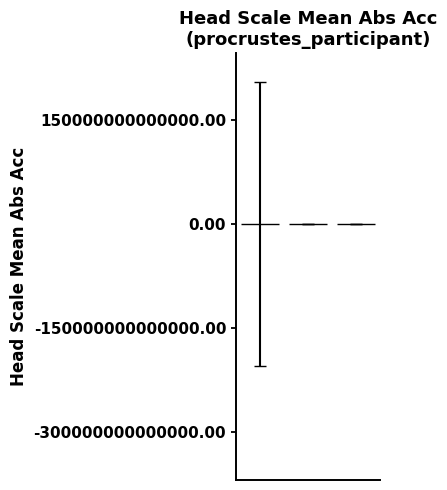

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_scale_rms:
  H: 0.028
  L: 0.029
  M: 0.031

=== procrustes_participant_head_scale_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -1333.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0833 -0.4009 -0.1979  0.0086  6.1229 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0000000 0.00000 
 Residual                   0.0004318 0.02078 
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   2.816e-02  2.339e-03  2.770e+02  12.035   <2e-16 ***
condition.L   9.113e-04  4.071e-03  2.770e+02   0.224   0.8230    
condition.Q  -2.808e-03  3.888e-03  2.770e+02  -0.722   0.4708    
window_index  3.998e-05  2.235e-05  2.770e+02   1.789   0.0

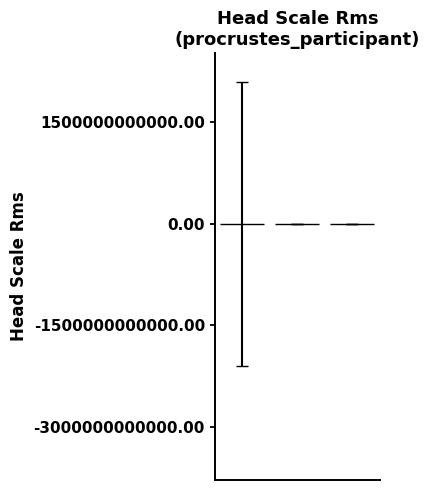

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_motion_mag_mean_abs_vel:
  H: 1.602
  L: 1.918
  M: 2.176

=== procrustes_participant_head_motion_mag_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 935

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9761 -0.4085 -0.2117  0.1025  6.1164 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.000    0.000   
 Residual                   1.557    1.248   
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    1.856141   0.140474 277.000000  13.213   <2e-16 ***
condition.L   -0.153466   0.244459 277.000000  -0.628    0.531    
condition.Q   -0.379610   0.233487 277.000000  -1.626    0.105    
window_index   0.001387   0.001342 277

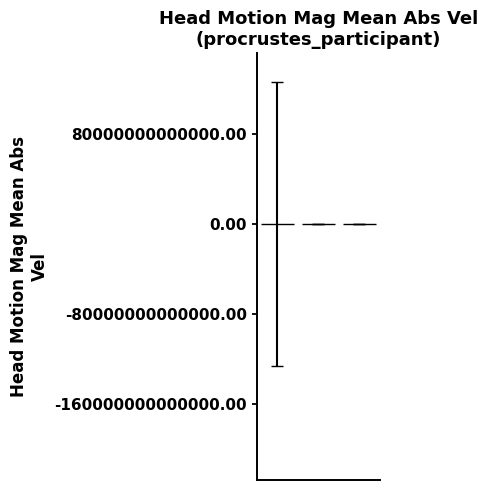

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_motion_mag_mean_abs_acc:
  H: 56.459
  L: 75.823
  M: 85.198

=== procrustes_participant_head_motion_mag_mean_abs_acc (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 3230.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6571 -0.3057 -0.1899 -0.0455  6.0592 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept)    0      0.00   
 Residual                   6191     78.68   
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   70.26195    8.85822 277.00000   7.932 5.36e-14 ***
condition.L  -10.03645   15.41548 277.00000  -0.651    0.516    
condition.Q  -17.67045   14.72356 277.00000  -1.200    0.231    
window_index   0.07259    0.08463 277.00

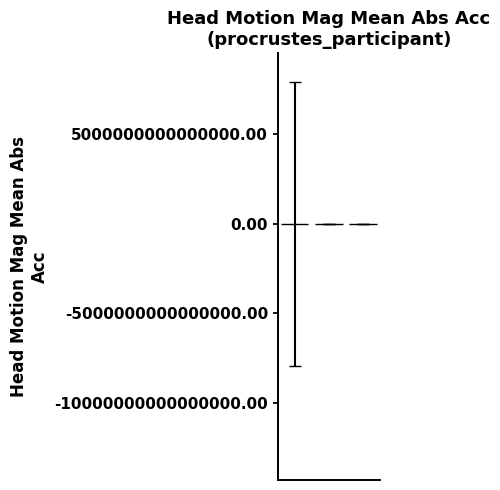

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_motion_mag_rms:
  H: 0.380
  L: 0.537
  M: 0.622

=== procrustes_participant_head_motion_mag_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 609.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5731 -0.3661 -0.2358  0.0032  5.7627 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.0000   0.000   
 Residual                   0.4803   0.693   
Number of obs: 281, groups:  participant_id, 3

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   4.976e-01  7.802e-02  2.770e+02   6.378 7.49e-10 ***
condition.L  -8.639e-02  1.358e-01  2.770e+02  -0.636    0.525    
condition.Q  -1.481e-01  1.297e-01  2.770e+02  -1.142    0.254    
window_index  4.993e-04  7.454e-04  2.770e+02   0.670 

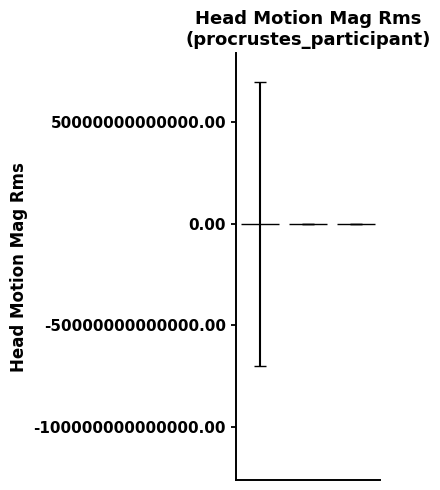


Analysis complete! Processed 87 metrics total


In [9]:
# Filter methods if user selected a subset
methods_to_analyze = pose_metrics_df["method"].unique()
results = {}

for method in methods_to_analyze:
    df_method = pose_metrics_df[pose_metrics_df["method"] == method]
    print(f"\nAnalyzing {method} normalization method...")
    results[method] = {}

    for metric in metric_cols:
        # Skip if column doesn't exist
        if metric not in df_method.columns:
            continue
        # Skip if column is all NaN
        if df_method[metric].dropna().empty:
            continue

        label = metric.replace("_", " ").title()
        pvals, means, cis = run_rpy2_lmer(df_method, metric, f"{method}_{metric}")

        if pvals is not None:
            results[method][metric] = {
                "pvals": pvals,
                "means": means,
                "cis": cis,
                "label": label
            }

            # Plots
            conds = ["L", "M", "H"]
            mean_vals = [means.get(c, float('nan')) for c in conds]
            sems = [(cis[c][1] - cis[c][0]) / 3.92 if c in cis else float('nan') for c in conds]
            pval_list = [
                pvals.get(("L", "M"), 1.0),
                pvals.get(("L", "H"), 1.0),
                pvals.get(("M", "H"), 1.0)
            ]

            fig, ax = plt.subplots(figsize=(4, 5))
            barplot_ax(ax, mean_vals, sems, pval_list, ylabel=label, metric_name=metric)
            ax.set_title(f"{label}\n({method})", fontsize=13, weight='bold')
            plt.tight_layout()
            plt.show()

print(f"\nAnalysis complete! Processed {sum(len(r) for r in results.values())} metrics total")